In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from os import path
from utils import plot_report

import pandas as pd
%matplotlib inline

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import numpy as np

import config

In [2]:
# training parameters
seed= config.seed

dr=0.8
lr2=1e-3
lr1=1e-4
lr=8e-4

num_epochs=5000
mini_batch_size=128

main_units=64
secondary_units=16
last_unit=8
lstm_units=64
num_classes=1

# radius or residues
feature='radius'

# if features is residues ''<coefficients>_' for example '17_' otherwhise ''
coefficients= '' if feature == 'radius' else '17_'

print_sample=False

In [3]:
score = 'accuracy'

#this data has been previously processed by airflow
features = pd.read_csv("/data/elekin/data/results/handwriting/tmp/windowed_data_augmentation_{}_{}_20220911.csv".format(feature, coefficients)) #TODO automate
features = features.set_index(features.columns[0]).sort_index()
print("Loaded data from CSV")
features.head(5)

Loaded data from CSV


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
C01_1,0.000000,139.620900,12.303175,74.603526,11.278530,53.647830,16.991655,35.022860,12.339670,32.053996,...,20.696314,20.918954,24.735220,24.312920,22.370285,23.583166,28.246445,30.232018,28.765377,30.611842
C01_1,139.620900,12.303175,74.603526,11.278530,53.647830,16.991655,35.022860,12.339670,32.053996,18.735860,...,20.918954,24.735220,24.312920,22.370285,23.583166,28.246445,30.232018,28.765377,30.611842,35.592459
C01_1,12.303175,74.603526,11.278530,53.647830,16.991655,35.022860,12.339670,32.053996,18.735860,20.204644,...,24.735220,24.312920,22.370285,23.583166,28.246445,30.232018,28.765377,30.611842,35.592459,38.775607
C01_1,74.603526,11.278530,53.647830,16.991655,35.022860,12.339670,32.053996,18.735860,20.204644,13.337827,...,24.312920,22.370285,23.583166,28.246445,30.232018,28.765377,30.611842,35.592459,38.775607,37.805279
C01_1,11.278530,53.647830,16.991655,35.022860,12.339670,32.053996,18.735860,20.204644,13.337827,22.690049,...,22.370285,23.583166,28.246445,30.232018,28.765377,30.611842,35.592459,38.775607,37.805279,39.197084


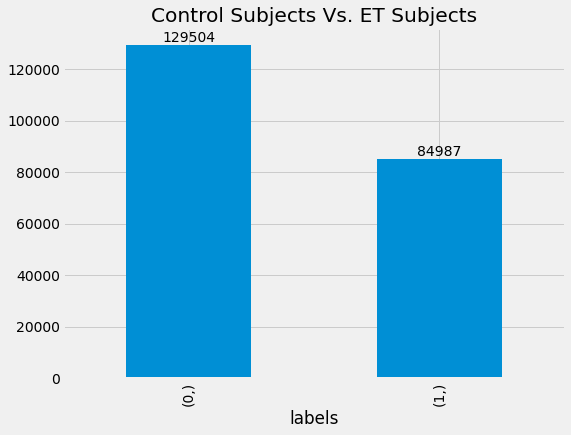

In [4]:
y = pd.read_csv("/data/elekin/data/results/handwriting/tmp/windowed_data_augmentation_{}_{}_20220911_labels.csv".format(feature, coefficients)) #TODO automate
y = y.set_index(y.columns[0]).sort_index()
ax = y.value_counts().plot.bar(title='Control Subjects Vs. ET Subjects', x='counts')
_ = ax.bar_label(ax.containers[0])

In [5]:
from sklearn import preprocessing
#lb = preprocessing.LabelBinarizer()
#y = lb.fit_transform(labels).astype(np.int16)
#y.shape
#binary labels
le = LabelEncoder().fit(y.values.ravel())
y = le.fit_transform(y.values.ravel()).astype(np.int16)
y

array([0, 0, 0, ..., 1, 1, 1], dtype=int16)

In [6]:
X=features.values.astype(np.float64)
X.shape

(214491, 50)

In [7]:
scaler = MinMaxScaler()
print(scaler.fit(X))
print(scaler.data_max_)
#print(scaler.mean_)
print(scaler.transform(X))

MinMaxScaler()
[8586.85432122 8586.85432122 8586.85432122 8586.85432122 8586.85432122
 8586.85432122 8586.85432122 8586.85432122 8586.85432122 8586.85432122
 8586.85432122 8586.85432122 8586.85432122 8586.85432122 8586.85432122
 8586.85432122 8586.85432122 8586.85432122 8586.85432122 8586.85432122
 8586.85432122 8586.85432122 8586.85432122 8586.85432122 8586.85432122
 8586.85432122 8586.85432122 8586.85432122 8586.85432122 8586.85432122
 8586.85432122 8586.85432122 8586.85432122 8586.85432122 8586.85432122
 8586.85432122 8586.85432122 8586.85432122 8586.85432122 8586.85432122
 8586.85432122 8586.85432122 8586.85432122 8586.85432122 8586.85432122
 8586.85432122 8586.85432122 8586.85432122 8586.85432122 8586.85432122]
[[0.         0.01625084 0.00142366 ... 0.00351162 0.00334082 0.00355585]
 [0.01625984 0.00142366 0.00867904 ... 0.00334082 0.00355585 0.00413588]
 [0.00143279 0.00867904 0.00130433 ... 0.00355585 0.00413588 0.00450659]
 ...
 [0.22555148 0.22752151 0.22758003 ... 0.24008635 

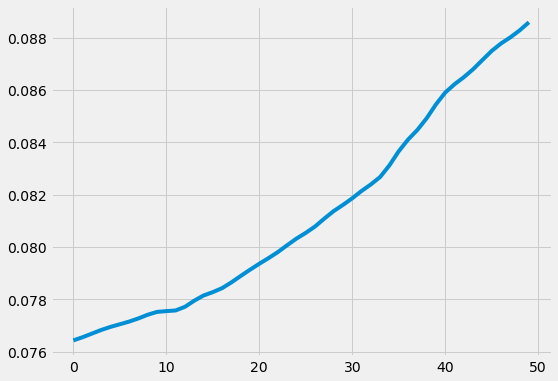

In [8]:
x_train, x_test, y_train, y_test = train_test_split(scaler.transform(X), y, test_size=0.33, random_state=seed)
plt.plot(x_train[10,:])

In [9]:
x_train.shape, x_test.shape

((143708, 50), (70783, 50))

In [10]:
#train_mean = x_train.mean()
#train_std = x_train.std()

#x_train = (x_train - train_mean) / train_std
#x_test = (x_test - train_mean) / train_std
#plt.plot(x_train[10,:])

In [11]:
num_features = x_train.shape[1]

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).take(len(x_train)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).take(len(x_test)).batch(mini_batch_size).prefetch(AUTOTUNE).cache()
steps_per_epoch = round(len(train_dataset)/mini_batch_size)

if print_sample:
    for feat, targ in test_dataset.take(10):
        print ('Features test: {}, Target: {}'.format(feat, targ))

    for feat, targ in test_dataset.take(10):
        print ('Features train: {}, Target: {}'.format(feat, targ))

print("{0} train batches and {1} test batches of {2} mini batch size and {3} steps per epoch".format(len(train_dataset), 
                                                                              len(test_dataset),
                                                                              mini_batch_size,
                                                                                steps_per_epoch))

1123 train batches and 553 test batches of 128 mini batch size and 9 steps per epoch


## FCNN ARCHITECTURE ANALISYS

Some training helpers functions

In [13]:
def get_callbacks():
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-4),
      ]

def compile_and_fit(model, train_dataset, test_dataset, optimizer=None, max_epochs=1000, loss='categorical_crossentropy'):
    
    tf.keras.backend.clear_session()# avoid clutter from old models and layers, especially when memory is limited
    tf.random.set_seed(seed) # establecemos la semilla para tensorflow
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    model.summary()
   
    history = model.fit(train_dataset, 
                        use_multiprocessing=True, 
                        validation_data=test_dataset, epochs=max_epochs, 
                        callbacks=get_callbacks(),
                        verbose=1, shuffle=False)
    return history

# Many models train better if you gradually reduce the learning rate during training. 
# Use optimizers.schedules to reduce the learning rate over time:
def get_optimizer(steps_per_epoch=1, lr=1e-4, multiplier=1000):
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(lr,
                                                                 decay_steps=steps_per_epoch*multiplier,
                                                                 decay_rate=1,
                                                                 staircase=False)
    return tf.keras.optimizers.Adam(lr_schedule)

In [14]:
size_histories = {}

In [15]:
inputs = tf.keras.Input(shape=(num_features,))

dense_1 = tf.keras.layers.Dense(main_units, activation=tf.nn.relu)(inputs)
5000 = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dense_1)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

size_histories['fcnn/tiny/sgd'] = compile_and_fit(model, train_dataset, 
                                              test_dataset,
#                                              optimizer=tf.keras.optimizers.Adam(lr), 
                                              optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs,
                                              loss='binary_crossentropy')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense (Dense)               (None, 64)                3264      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5000


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


1123/1123 [==============================] - 2s 2ms/step - loss: 0.6745 - accuracy: 0.5995 - val_loss: 0.6725 - val_accuracy: 0.6006
Epoch 2/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6702 - accuracy: 0.6054 - val_loss: 0.6718 - val_accuracy: 0.6006
Epoch 3/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6697 - accuracy: 0.6054 - val_loss: 0.6718 - val_accuracy: 0.6006
Epoch 4/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6696 - accuracy: 0.6054 - val_loss: 0.6718 - val_accuracy: 0.6006
Epoch 5/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6696 - accuracy: 0.6053 - val_loss: 0.6717 - val_accuracy: 0.6006
Epoch 6/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6695 - accuracy: 0.6053 - val_loss: 0.6717 - val_accuracy: 0.6006
Epoch 7/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6694 - accuracy: 0.6053 - val_loss: 0.6716 - val_accuracy

Epoch 57/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6655 - accuracy: 0.6089 - val_loss: 0.6678 - val_accuracy: 0.6043
Epoch 58/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6653 - accuracy: 0.6089 - val_loss: 0.6676 - val_accuracy: 0.6045
Epoch 59/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6652 - accuracy: 0.6091 - val_loss: 0.6675 - val_accuracy: 0.6046
Epoch 60/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6650 - accuracy: 0.6092 - val_loss: 0.6674 - val_accuracy: 0.6048
Epoch 61/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6649 - accuracy: 0.6095 - val_loss: 0.6672 - val_accuracy: 0.6050
Epoch 62/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6648 - accuracy: 0.6096 - val_loss: 0.6671 - val_accuracy: 0.6052
Epoch 63/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6646 - accuracy: 0.6099 - val_loss: 0

1123/1123 [==============================] - 2s 1ms/step - loss: 0.6561 - accuracy: 0.6215 - val_loss: 0.6585 - val_accuracy: 0.6180
Epoch 113/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6559 - accuracy: 0.6219 - val_loss: 0.6584 - val_accuracy: 0.6184
Epoch 114/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6557 - accuracy: 0.6224 - val_loss: 0.6582 - val_accuracy: 0.6187
Epoch 115/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6556 - accuracy: 0.6227 - val_loss: 0.6580 - val_accuracy: 0.6193
Epoch 116/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6554 - accuracy: 0.6231 - val_loss: 0.6579 - val_accuracy: 0.6199
Epoch 117/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6553 - accuracy: 0.6234 - val_loss: 0.6577 - val_accuracy: 0.6206
Epoch 118/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6551 - accuracy: 0.6238 - val_loss: 0.6576 - 

1123/1123 [==============================] - 2s 1ms/step - loss: 0.6493 - accuracy: 0.6403 - val_loss: 0.6519 - val_accuracy: 0.6359
Epoch 168/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6493 - accuracy: 0.6404 - val_loss: 0.6518 - val_accuracy: 0.6360
Epoch 169/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6492 - accuracy: 0.6405 - val_loss: 0.6517 - val_accuracy: 0.6361
Epoch 170/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6491 - accuracy: 0.6406 - val_loss: 0.6516 - val_accuracy: 0.6361
Epoch 171/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6490 - accuracy: 0.6408 - val_loss: 0.6515 - val_accuracy: 0.6361
Epoch 172/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6489 - accuracy: 0.6408 - val_loss: 0.6514 - val_accuracy: 0.6362
Epoch 173/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6489 - accuracy: 0.6408 - val_loss: 0.6514 - 

1123/1123 [==============================] - 2s 1ms/step - loss: 0.6458 - accuracy: 0.6397 - val_loss: 0.6486 - val_accuracy: 0.6335
Epoch 223/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6458 - accuracy: 0.6397 - val_loss: 0.6486 - val_accuracy: 0.6335
Epoch 224/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6457 - accuracy: 0.6395 - val_loss: 0.6486 - val_accuracy: 0.6334
Epoch 225/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6457 - accuracy: 0.6394 - val_loss: 0.6486 - val_accuracy: 0.6335
Epoch 226/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6457 - accuracy: 0.6393 - val_loss: 0.6485 - val_accuracy: 0.6334
Epoch 227/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6456 - accuracy: 0.6393 - val_loss: 0.6485 - val_accuracy: 0.6334
Epoch 228/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6456 - accuracy: 0.6391 - val_loss: 0.6485 - 

1123/1123 [==============================] - 2s 2ms/step - loss: 0.6445 - accuracy: 0.6390 - val_loss: 0.6477 - val_accuracy: 0.6319
Epoch 278/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6445 - accuracy: 0.6390 - val_loss: 0.6477 - val_accuracy: 0.6322
Epoch 279/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6445 - accuracy: 0.6390 - val_loss: 0.6477 - val_accuracy: 0.6321
Epoch 280/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6445 - accuracy: 0.6389 - val_loss: 0.6476 - val_accuracy: 0.6320
Epoch 281/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6445 - accuracy: 0.6390 - val_loss: 0.6475 - val_accuracy: 0.6321
Epoch 282/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6445 - accuracy: 0.6391 - val_loss: 0.6475 - val_accuracy: 0.6322
Epoch 283/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6444 - accuracy: 0.6390 - val_loss: 0.6476 - 

1123/1123 [==============================] - 2s 1ms/step - loss: 0.6437 - accuracy: 0.6398 - val_loss: 0.6467 - val_accuracy: 0.6336
Epoch 333/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6437 - accuracy: 0.6398 - val_loss: 0.6467 - val_accuracy: 0.6335
Epoch 334/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6437 - accuracy: 0.6398 - val_loss: 0.6467 - val_accuracy: 0.6336
Epoch 335/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6436 - accuracy: 0.6399 - val_loss: 0.6467 - val_accuracy: 0.6337
Epoch 336/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6436 - accuracy: 0.6400 - val_loss: 0.6467 - val_accuracy: 0.6337
Epoch 337/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6436 - accuracy: 0.6400 - val_loss: 0.6466 - val_accuracy: 0.6337
Epoch 338/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6436 - accuracy: 0.6399 - val_loss: 0.6466 - 

1123/1123 [==============================] - 2s 1ms/step - loss: 0.6430 - accuracy: 0.6411 - val_loss: 0.6460 - val_accuracy: 0.6350
Epoch 388/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6430 - accuracy: 0.6411 - val_loss: 0.6460 - val_accuracy: 0.6351
Epoch 389/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6430 - accuracy: 0.6410 - val_loss: 0.6460 - val_accuracy: 0.6351
Epoch 390/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6430 - accuracy: 0.6411 - val_loss: 0.6460 - val_accuracy: 0.6350
Epoch 391/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6430 - accuracy: 0.6412 - val_loss: 0.6460 - val_accuracy: 0.6352
Epoch 392/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6430 - accuracy: 0.6411 - val_loss: 0.6460 - val_accuracy: 0.6352
Epoch 393/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6429 - accuracy: 0.6412 - val_loss: 0.6460 - 

1123/1123 [==============================] - 2s 2ms/step - loss: 0.6422 - accuracy: 0.6427 - val_loss: 0.6452 - val_accuracy: 0.6366
Epoch 443/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6421 - accuracy: 0.6427 - val_loss: 0.6452 - val_accuracy: 0.6367
Epoch 444/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6421 - accuracy: 0.6427 - val_loss: 0.6452 - val_accuracy: 0.6367
Epoch 445/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6421 - accuracy: 0.6427 - val_loss: 0.6452 - val_accuracy: 0.6366
Epoch 446/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6421 - accuracy: 0.6428 - val_loss: 0.6452 - val_accuracy: 0.6367
Epoch 447/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6421 - accuracy: 0.6428 - val_loss: 0.6451 - val_accuracy: 0.6368
Epoch 448/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6420 - accuracy: 0.6428 - val_loss: 0.6451 - 

1123/1123 [==============================] - 2s 2ms/step - loss: 0.6412 - accuracy: 0.6444 - val_loss: 0.6442 - val_accuracy: 0.6383
Epoch 498/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6412 - accuracy: 0.6445 - val_loss: 0.6443 - val_accuracy: 0.6384
Epoch 499/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6411 - accuracy: 0.6444 - val_loss: 0.6442 - val_accuracy: 0.6384
Epoch 500/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6411 - accuracy: 0.6445 - val_loss: 0.6442 - val_accuracy: 0.6384
Epoch 501/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6411 - accuracy: 0.6446 - val_loss: 0.6442 - val_accuracy: 0.6385
Epoch 502/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6411 - accuracy: 0.6446 - val_loss: 0.6442 - val_accuracy: 0.6386
Epoch 503/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6411 - accuracy: 0.6445 - val_loss: 0.6442 - 

1123/1123 [==============================] - 2s 2ms/step - loss: 0.6401 - accuracy: 0.6468 - val_loss: 0.6432 - val_accuracy: 0.6408
Epoch 553/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6401 - accuracy: 0.6468 - val_loss: 0.6432 - val_accuracy: 0.6409
Epoch 554/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6401 - accuracy: 0.6469 - val_loss: 0.6432 - val_accuracy: 0.6408
Epoch 555/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6401 - accuracy: 0.6469 - val_loss: 0.6432 - val_accuracy: 0.6410
Epoch 556/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6400 - accuracy: 0.6469 - val_loss: 0.6432 - val_accuracy: 0.6409
Epoch 557/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6400 - accuracy: 0.6471 - val_loss: 0.6432 - val_accuracy: 0.6410
Epoch 558/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6400 - accuracy: 0.6470 - val_loss: 0.6431 - 

1123/1123 [==============================] - 2s 1ms/step - loss: 0.6390 - accuracy: 0.6492 - val_loss: 0.6421 - val_accuracy: 0.6435
Epoch 608/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6390 - accuracy: 0.6492 - val_loss: 0.6420 - val_accuracy: 0.6435
Epoch 609/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6389 - accuracy: 0.6493 - val_loss: 0.6421 - val_accuracy: 0.6433
Epoch 610/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6389 - accuracy: 0.6493 - val_loss: 0.6420 - val_accuracy: 0.6436
Epoch 611/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6389 - accuracy: 0.6493 - val_loss: 0.6420 - val_accuracy: 0.6436
Epoch 612/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6389 - accuracy: 0.6494 - val_loss: 0.6420 - val_accuracy: 0.6438
Epoch 613/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6389 - accuracy: 0.6495 - val_loss: 0.6419 - 

1123/1123 [==============================] - 2s 1ms/step - loss: 0.6378 - accuracy: 0.6519 - val_loss: 0.6410 - val_accuracy: 0.6468
Epoch 663/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6378 - accuracy: 0.6519 - val_loss: 0.6408 - val_accuracy: 0.6467
Epoch 664/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6377 - accuracy: 0.6519 - val_loss: 0.6408 - val_accuracy: 0.6468
Epoch 665/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6377 - accuracy: 0.6521 - val_loss: 0.6409 - val_accuracy: 0.6467
Epoch 666/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6377 - accuracy: 0.6522 - val_loss: 0.6408 - val_accuracy: 0.6468
Epoch 667/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6376 - accuracy: 0.6522 - val_loss: 0.6407 - val_accuracy: 0.6469
Epoch 668/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6376 - accuracy: 0.6524 - val_loss: 0.6407 - 

1123/1123 [==============================] - 2s 2ms/step - loss: 0.6360 - accuracy: 0.6569 - val_loss: 0.6390 - val_accuracy: 0.6522
Epoch 718/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6360 - accuracy: 0.6570 - val_loss: 0.6391 - val_accuracy: 0.6521
Epoch 719/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6360 - accuracy: 0.6570 - val_loss: 0.6391 - val_accuracy: 0.6523
Epoch 720/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6359 - accuracy: 0.6571 - val_loss: 0.6390 - val_accuracy: 0.6522
Epoch 721/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6359 - accuracy: 0.6571 - val_loss: 0.6390 - val_accuracy: 0.6523
Epoch 722/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6358 - accuracy: 0.6573 - val_loss: 0.6390 - val_accuracy: 0.6524
Epoch 723/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6358 - accuracy: 0.6572 - val_loss: 0.6389 - 

1123/1123 [==============================] - 2s 1ms/step - loss: 0.6330 - accuracy: 0.6612 - val_loss: 0.6361 - val_accuracy: 0.6577
Epoch 773/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6329 - accuracy: 0.6614 - val_loss: 0.6361 - val_accuracy: 0.6577
Epoch 774/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6328 - accuracy: 0.6614 - val_loss: 0.6360 - val_accuracy: 0.6576
Epoch 775/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6327 - accuracy: 0.6615 - val_loss: 0.6360 - val_accuracy: 0.6577
Epoch 776/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6326 - accuracy: 0.6617 - val_loss: 0.6358 - val_accuracy: 0.6580
Epoch 777/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6326 - accuracy: 0.6618 - val_loss: 0.6358 - val_accuracy: 0.6580
Epoch 778/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6325 - accuracy: 0.6618 - val_loss: 0.6357 - 

1123/1123 [==============================] - 2s 1ms/step - loss: 0.6285 - accuracy: 0.6672 - val_loss: 0.6318 - val_accuracy: 0.6642
Epoch 828/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6284 - accuracy: 0.6674 - val_loss: 0.6317 - val_accuracy: 0.6641
Epoch 829/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6283 - accuracy: 0.6673 - val_loss: 0.6316 - val_accuracy: 0.6643
Epoch 830/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6283 - accuracy: 0.6675 - val_loss: 0.6316 - val_accuracy: 0.6643
Epoch 831/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6282 - accuracy: 0.6676 - val_loss: 0.6316 - val_accuracy: 0.6644
Epoch 832/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6281 - accuracy: 0.6677 - val_loss: 0.6314 - val_accuracy: 0.6645
Epoch 833/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6281 - accuracy: 0.6678 - val_loss: 0.6315 - 

1123/1123 [==============================] - 2s 1ms/step - loss: 0.6255 - accuracy: 0.6727 - val_loss: 0.6291 - val_accuracy: 0.6696
Epoch 883/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6255 - accuracy: 0.6728 - val_loss: 0.6290 - val_accuracy: 0.6699
Epoch 884/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6254 - accuracy: 0.6729 - val_loss: 0.6290 - val_accuracy: 0.6701
Epoch 885/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6254 - accuracy: 0.6730 - val_loss: 0.6290 - val_accuracy: 0.6699
Epoch 886/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6253 - accuracy: 0.6731 - val_loss: 0.6289 - val_accuracy: 0.6700
Epoch 887/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6253 - accuracy: 0.6732 - val_loss: 0.6289 - val_accuracy: 0.6702
Epoch 888/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6253 - accuracy: 0.6732 - val_loss: 0.6289 - 

1123/1123 [==============================] - 2s 1ms/step - loss: 0.6237 - accuracy: 0.6776 - val_loss: 0.6276 - val_accuracy: 0.6739
Epoch 938/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6237 - accuracy: 0.6777 - val_loss: 0.6276 - val_accuracy: 0.6741
Epoch 939/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6237 - accuracy: 0.6776 - val_loss: 0.6275 - val_accuracy: 0.6742
Epoch 940/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6236 - accuracy: 0.6778 - val_loss: 0.6275 - val_accuracy: 0.6744
Epoch 941/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6236 - accuracy: 0.6779 - val_loss: 0.6275 - val_accuracy: 0.6743
Epoch 942/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6236 - accuracy: 0.6779 - val_loss: 0.6274 - val_accuracy: 0.6748
Epoch 943/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6236 - accuracy: 0.6780 - val_loss: 0.6274 - 

1123/1123 [==============================] - 2s 2ms/step - loss: 0.6224 - accuracy: 0.6811 - val_loss: 0.6265 - val_accuracy: 0.6766
Epoch 993/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6224 - accuracy: 0.6812 - val_loss: 0.6265 - val_accuracy: 0.6765
Epoch 994/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6224 - accuracy: 0.6812 - val_loss: 0.6265 - val_accuracy: 0.6768
Epoch 995/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6224 - accuracy: 0.6814 - val_loss: 0.6264 - val_accuracy: 0.6770
Epoch 996/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6223 - accuracy: 0.6814 - val_loss: 0.6263 - val_accuracy: 0.6770
Epoch 997/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6223 - accuracy: 0.6814 - val_loss: 0.6265 - val_accuracy: 0.6766
Epoch 998/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6223 - accuracy: 0.6817 - val_loss: 0.6264 - 

1123/1123 [==============================] - 2s 1ms/step - loss: 0.6213 - accuracy: 0.6845 - val_loss: 0.6257 - val_accuracy: 0.6793
Epoch 1048/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6213 - accuracy: 0.6844 - val_loss: 0.6256 - val_accuracy: 0.6795
Epoch 1049/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6213 - accuracy: 0.6845 - val_loss: 0.6255 - val_accuracy: 0.6792
Epoch 1050/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6213 - accuracy: 0.6845 - val_loss: 0.6257 - val_accuracy: 0.6792
Epoch 1051/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6213 - accuracy: 0.6845 - val_loss: 0.6257 - val_accuracy: 0.6789
Epoch 1052/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6213 - accuracy: 0.6848 - val_loss: 0.6256 - val_accuracy: 0.6794
Epoch 1053/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6212 - accuracy: 0.6847 - val_loss: 0.6

1123/1123 [==============================] - 2s 1ms/step - loss: 0.6204 - accuracy: 0.6870 - val_loss: 0.6250 - val_accuracy: 0.6808
Epoch 1103/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6204 - accuracy: 0.6869 - val_loss: 0.6250 - val_accuracy: 0.6809
Epoch 1104/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6204 - accuracy: 0.6870 - val_loss: 0.6249 - val_accuracy: 0.6810
Epoch 1105/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6204 - accuracy: 0.6871 - val_loss: 0.6250 - val_accuracy: 0.6808
Epoch 1106/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6204 - accuracy: 0.6870 - val_loss: 0.6249 - val_accuracy: 0.6810
Epoch 1107/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6203 - accuracy: 0.6870 - val_loss: 0.6248 - val_accuracy: 0.6814
Epoch 1108/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6203 - accuracy: 0.6871 - val_loss: 0.6

1123/1123 [==============================] - 2s 1ms/step - loss: 0.6196 - accuracy: 0.6891 - val_loss: 0.6244 - val_accuracy: 0.6823
Epoch 1158/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6196 - accuracy: 0.6890 - val_loss: 0.6240 - val_accuracy: 0.6834
Epoch 1159/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6195 - accuracy: 0.6892 - val_loss: 0.6243 - val_accuracy: 0.6823
Epoch 1160/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6195 - accuracy: 0.6892 - val_loss: 0.6243 - val_accuracy: 0.6821
Epoch 1161/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6195 - accuracy: 0.6892 - val_loss: 0.6241 - val_accuracy: 0.6825
Epoch 1162/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6195 - accuracy: 0.6893 - val_loss: 0.6246 - val_accuracy: 0.6812
Epoch 1163/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6195 - accuracy: 0.6893 - val_loss: 0.6

1123/1123 [==============================] - 2s 2ms/step - loss: 0.6188 - accuracy: 0.6912 - val_loss: 0.6239 - val_accuracy: 0.6832
Epoch 1213/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6188 - accuracy: 0.6913 - val_loss: 0.6238 - val_accuracy: 0.6833
Epoch 1214/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6188 - accuracy: 0.6913 - val_loss: 0.6236 - val_accuracy: 0.6839
Epoch 1215/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6187 - accuracy: 0.6912 - val_loss: 0.6239 - val_accuracy: 0.6824
Epoch 1216/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6188 - accuracy: 0.6913 - val_loss: 0.6237 - val_accuracy: 0.6833
Epoch 1217/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6187 - accuracy: 0.6914 - val_loss: 0.6239 - val_accuracy: 0.6826
Epoch 1218/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6187 - accuracy: 0.6913 - val_loss: 0.6

1123/1123 [==============================] - 2s 1ms/step - loss: 0.6181 - accuracy: 0.6927 - val_loss: 0.6229 - val_accuracy: 0.6858
Epoch 1268/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6181 - accuracy: 0.6925 - val_loss: 0.6232 - val_accuracy: 0.6847
Epoch 1269/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6181 - accuracy: 0.6926 - val_loss: 0.6231 - val_accuracy: 0.6856
Epoch 1270/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6181 - accuracy: 0.6927 - val_loss: 0.6233 - val_accuracy: 0.6847
Epoch 1271/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6181 - accuracy: 0.6927 - val_loss: 0.6232 - val_accuracy: 0.6846
Epoch 1272/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6181 - accuracy: 0.6928 - val_loss: 0.6234 - val_accuracy: 0.6842
Epoch 1273/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6181 - accuracy: 0.6926 - val_loss: 0.6

1123/1123 [==============================] - 2s 1ms/step - loss: 0.6176 - accuracy: 0.6939 - val_loss: 0.6228 - val_accuracy: 0.6855
Epoch 1323/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6176 - accuracy: 0.6938 - val_loss: 0.6234 - val_accuracy: 0.6838
Epoch 1324/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6175 - accuracy: 0.6941 - val_loss: 0.6233 - val_accuracy: 0.6841
Epoch 1325/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6175 - accuracy: 0.6940 - val_loss: 0.6224 - val_accuracy: 0.6866
Epoch 1326/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6175 - accuracy: 0.6938 - val_loss: 0.6225 - val_accuracy: 0.6865
Epoch 1327/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6175 - accuracy: 0.6940 - val_loss: 0.6228 - val_accuracy: 0.6856
Epoch 1328/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6175 - accuracy: 0.6940 - val_loss: 0.6

1123/1123 [==============================] - 2s 1ms/step - loss: 0.6170 - accuracy: 0.6953 - val_loss: 0.6222 - val_accuracy: 0.6883
Epoch 1378/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6171 - accuracy: 0.6952 - val_loss: 0.6224 - val_accuracy: 0.6868
Epoch 1379/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6170 - accuracy: 0.6952 - val_loss: 0.6225 - val_accuracy: 0.6865
Epoch 1380/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6170 - accuracy: 0.6953 - val_loss: 0.6221 - val_accuracy: 0.6881
Epoch 1381/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6170 - accuracy: 0.6955 - val_loss: 0.6222 - val_accuracy: 0.6882
Epoch 1382/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6170 - accuracy: 0.6953 - val_loss: 0.6225 - val_accuracy: 0.6869
Epoch 1383/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6170 - accuracy: 0.6952 - val_loss: 0.6

1123/1123 [==============================] - 2s 1ms/step - loss: 0.6166 - accuracy: 0.6964 - val_loss: 0.6220 - val_accuracy: 0.6878
Epoch 1433/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6166 - accuracy: 0.6965 - val_loss: 0.6222 - val_accuracy: 0.6872
Epoch 1434/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6166 - accuracy: 0.6963 - val_loss: 0.6217 - val_accuracy: 0.6896
Epoch 1435/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6166 - accuracy: 0.6965 - val_loss: 0.6220 - val_accuracy: 0.6883
Epoch 1436/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6166 - accuracy: 0.6965 - val_loss: 0.6219 - val_accuracy: 0.6885
Epoch 1437/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6165 - accuracy: 0.6965 - val_loss: 0.6220 - val_accuracy: 0.6887
Epoch 1438/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6165 - accuracy: 0.6965 - val_loss: 0.6

1123/1123 [==============================] - 2s 1ms/step - loss: 0.6161 - accuracy: 0.6975 - val_loss: 0.6217 - val_accuracy: 0.6890
Epoch 1488/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6161 - accuracy: 0.6975 - val_loss: 0.6218 - val_accuracy: 0.6886
Epoch 1489/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6161 - accuracy: 0.6974 - val_loss: 0.6214 - val_accuracy: 0.6899
Epoch 1490/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6161 - accuracy: 0.6975 - val_loss: 0.6218 - val_accuracy: 0.6880
Epoch 1491/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6161 - accuracy: 0.6973 - val_loss: 0.6211 - val_accuracy: 0.6901
Epoch 1492/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6161 - accuracy: 0.6974 - val_loss: 0.6217 - val_accuracy: 0.6885
Epoch 1493/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6161 - accuracy: 0.6975 - val_loss: 0.6

1123/1123 [==============================] - 2s 2ms/step - loss: 0.6157 - accuracy: 0.6983 - val_loss: 0.6210 - val_accuracy: 0.6911
Epoch 1543/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6157 - accuracy: 0.6984 - val_loss: 0.6213 - val_accuracy: 0.6893
Epoch 1544/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6157 - accuracy: 0.6984 - val_loss: 0.6209 - val_accuracy: 0.6908
Epoch 1545/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6157 - accuracy: 0.6984 - val_loss: 0.6213 - val_accuracy: 0.6892
Epoch 1546/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6157 - accuracy: 0.6984 - val_loss: 0.6210 - val_accuracy: 0.6911
Epoch 1547/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6157 - accuracy: 0.6984 - val_loss: 0.6210 - val_accuracy: 0.6904
Epoch 1548/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6157 - accuracy: 0.6984 - val_loss: 0.6

1123/1123 [==============================] - 2s 2ms/step - loss: 0.6153 - accuracy: 0.6993 - val_loss: 0.6208 - val_accuracy: 0.6904
Epoch 1598/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6153 - accuracy: 0.6993 - val_loss: 0.6209 - val_accuracy: 0.6901
Epoch 1599/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6153 - accuracy: 0.6993 - val_loss: 0.6210 - val_accuracy: 0.6899
Epoch 1600/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6153 - accuracy: 0.6993 - val_loss: 0.6204 - val_accuracy: 0.6917
Epoch 1601/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6153 - accuracy: 0.6993 - val_loss: 0.6204 - val_accuracy: 0.6919
Epoch 1602/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6153 - accuracy: 0.6994 - val_loss: 0.6208 - val_accuracy: 0.6904
Epoch 1603/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6153 - accuracy: 0.6992 - val_loss: 0.6

1123/1123 [==============================] - 2s 2ms/step - loss: 0.6149 - accuracy: 0.6999 - val_loss: 0.6204 - val_accuracy: 0.6905
Epoch 1653/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6149 - accuracy: 0.7000 - val_loss: 0.6205 - val_accuracy: 0.6905
Epoch 1654/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6149 - accuracy: 0.7000 - val_loss: 0.6204 - val_accuracy: 0.6915
Epoch 1655/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6149 - accuracy: 0.7001 - val_loss: 0.6201 - val_accuracy: 0.6921
Epoch 1656/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6149 - accuracy: 0.7001 - val_loss: 0.6205 - val_accuracy: 0.6911
Epoch 1657/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6149 - accuracy: 0.7001 - val_loss: 0.6203 - val_accuracy: 0.6912
Epoch 1658/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6149 - accuracy: 0.7002 - val_loss: 0.6

1123/1123 [==============================] - 2s 1ms/step - loss: 0.6052 - accuracy: 0.7041 - val_loss: 0.6099 - val_accuracy: 0.6982
Epoch 1708/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6051 - accuracy: 0.7041 - val_loss: 0.6097 - val_accuracy: 0.6977
Epoch 1709/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6050 - accuracy: 0.7042 - val_loss: 0.6101 - val_accuracy: 0.6967
Epoch 1710/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6050 - accuracy: 0.7040 - val_loss: 0.6098 - val_accuracy: 0.6971
Epoch 1711/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6049 - accuracy: 0.7038 - val_loss: 0.6095 - val_accuracy: 0.6975
Epoch 1712/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6048 - accuracy: 0.7039 - val_loss: 0.6093 - val_accuracy: 0.6990
Epoch 1713/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6047 - accuracy: 0.7038 - val_loss: 0.6

1123/1123 [==============================] - 2s 2ms/step - loss: 0.6026 - accuracy: 0.7016 - val_loss: 0.6072 - val_accuracy: 0.6965
Epoch 1763/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6026 - accuracy: 0.7016 - val_loss: 0.6073 - val_accuracy: 0.6962
Epoch 1764/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6025 - accuracy: 0.7017 - val_loss: 0.6075 - val_accuracy: 0.6960
Epoch 1765/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6025 - accuracy: 0.7015 - val_loss: 0.6073 - val_accuracy: 0.6962
Epoch 1766/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6025 - accuracy: 0.7015 - val_loss: 0.6075 - val_accuracy: 0.6957
Epoch 1767/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6025 - accuracy: 0.7015 - val_loss: 0.6072 - val_accuracy: 0.6960
Epoch 1768/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6024 - accuracy: 0.7016 - val_loss: 0.6

1123/1123 [==============================] - 2s 2ms/step - loss: 0.6014 - accuracy: 0.7011 - val_loss: 0.6062 - val_accuracy: 0.6947
Epoch 1818/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6014 - accuracy: 0.7010 - val_loss: 0.6063 - val_accuracy: 0.6947
Epoch 1819/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6013 - accuracy: 0.7010 - val_loss: 0.6060 - val_accuracy: 0.6955
Epoch 1820/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6013 - accuracy: 0.7012 - val_loss: 0.6060 - val_accuracy: 0.6955
Epoch 1821/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6013 - accuracy: 0.7011 - val_loss: 0.6059 - val_accuracy: 0.6954
Epoch 1822/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6013 - accuracy: 0.7011 - val_loss: 0.6061 - val_accuracy: 0.6952
Epoch 1823/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6013 - accuracy: 0.7012 - val_loss: 0.6

1123/1123 [==============================] - 2s 2ms/step - loss: 0.6004 - accuracy: 0.7013 - val_loss: 0.6051 - val_accuracy: 0.6955
Epoch 1873/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6004 - accuracy: 0.7013 - val_loss: 0.6050 - val_accuracy: 0.6956
Epoch 1874/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6004 - accuracy: 0.7014 - val_loss: 0.6050 - val_accuracy: 0.6955
Epoch 1875/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.6004 - accuracy: 0.7012 - val_loss: 0.6052 - val_accuracy: 0.6954
Epoch 1876/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6003 - accuracy: 0.7013 - val_loss: 0.6051 - val_accuracy: 0.6954
Epoch 1877/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6003 - accuracy: 0.7012 - val_loss: 0.6051 - val_accuracy: 0.6953
Epoch 1878/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6003 - accuracy: 0.7014 - val_loss: 0.6

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5995 - accuracy: 0.7015 - val_loss: 0.6045 - val_accuracy: 0.6952
Epoch 1928/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5995 - accuracy: 0.7017 - val_loss: 0.6042 - val_accuracy: 0.6956
Epoch 1929/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5994 - accuracy: 0.7017 - val_loss: 0.6042 - val_accuracy: 0.6955
Epoch 1930/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5994 - accuracy: 0.7017 - val_loss: 0.6044 - val_accuracy: 0.6951
Epoch 1931/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5994 - accuracy: 0.7016 - val_loss: 0.6041 - val_accuracy: 0.6956
Epoch 1932/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5994 - accuracy: 0.7017 - val_loss: 0.6042 - val_accuracy: 0.6953
Epoch 1933/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5994 - accuracy: 0.7016 - val_loss: 0.6

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5986 - accuracy: 0.7024 - val_loss: 0.6036 - val_accuracy: 0.6956
Epoch 1983/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5986 - accuracy: 0.7024 - val_loss: 0.6035 - val_accuracy: 0.6955
Epoch 1984/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5986 - accuracy: 0.7023 - val_loss: 0.6037 - val_accuracy: 0.6954
Epoch 1985/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5986 - accuracy: 0.7023 - val_loss: 0.6034 - val_accuracy: 0.6962
Epoch 1986/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5985 - accuracy: 0.7025 - val_loss: 0.6036 - val_accuracy: 0.6956
Epoch 1987/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5985 - accuracy: 0.7024 - val_loss: 0.6032 - val_accuracy: 0.6964
Epoch 1988/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5985 - accuracy: 0.7024 - val_loss: 0.6

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5978 - accuracy: 0.7025 - val_loss: 0.6025 - val_accuracy: 0.6967
Epoch 2038/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5978 - accuracy: 0.7027 - val_loss: 0.6025 - val_accuracy: 0.6969
Epoch 2039/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5978 - accuracy: 0.7027 - val_loss: 0.6028 - val_accuracy: 0.6964
Epoch 2040/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5977 - accuracy: 0.7025 - val_loss: 0.6025 - val_accuracy: 0.6963
Epoch 2041/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5977 - accuracy: 0.7026 - val_loss: 0.6025 - val_accuracy: 0.6967
Epoch 2042/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5977 - accuracy: 0.7026 - val_loss: 0.6027 - val_accuracy: 0.6960
Epoch 2043/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5977 - accuracy: 0.7026 - val_loss: 0.6

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5970 - accuracy: 0.7028 - val_loss: 0.6020 - val_accuracy: 0.6963
Epoch 2093/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5970 - accuracy: 0.7029 - val_loss: 0.6021 - val_accuracy: 0.6964
Epoch 2094/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5970 - accuracy: 0.7026 - val_loss: 0.6018 - val_accuracy: 0.6971
Epoch 2095/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5969 - accuracy: 0.7027 - val_loss: 0.6022 - val_accuracy: 0.6962
Epoch 2096/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5970 - accuracy: 0.7027 - val_loss: 0.6018 - val_accuracy: 0.6971
Epoch 2097/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5969 - accuracy: 0.7028 - val_loss: 0.6023 - val_accuracy: 0.6961
Epoch 2098/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5969 - accuracy: 0.7027 - val_loss: 0.6

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5962 - accuracy: 0.7029 - val_loss: 0.6011 - val_accuracy: 0.6978
Epoch 2148/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5962 - accuracy: 0.7029 - val_loss: 0.6010 - val_accuracy: 0.6978
Epoch 2149/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5961 - accuracy: 0.7030 - val_loss: 0.6010 - val_accuracy: 0.6978
Epoch 2150/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5962 - accuracy: 0.7030 - val_loss: 0.6010 - val_accuracy: 0.6979
Epoch 2151/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5961 - accuracy: 0.7029 - val_loss: 0.6011 - val_accuracy: 0.6977
Epoch 2152/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5961 - accuracy: 0.7031 - val_loss: 0.6009 - val_accuracy: 0.6980
Epoch 2153/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5961 - accuracy: 0.7030 - val_loss: 0.6

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5954 - accuracy: 0.7034 - val_loss: 0.6002 - val_accuracy: 0.6986
Epoch 2203/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5954 - accuracy: 0.7033 - val_loss: 0.6002 - val_accuracy: 0.6987
Epoch 2204/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5953 - accuracy: 0.7034 - val_loss: 0.6004 - val_accuracy: 0.6981
Epoch 2205/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5953 - accuracy: 0.7035 - val_loss: 0.6003 - val_accuracy: 0.6983
Epoch 2206/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5954 - accuracy: 0.7035 - val_loss: 0.6007 - val_accuracy: 0.6972
Epoch 2207/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5953 - accuracy: 0.7034 - val_loss: 0.6002 - val_accuracy: 0.6986
Epoch 2208/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5953 - accuracy: 0.7034 - val_loss: 0.6

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5946 - accuracy: 0.7036 - val_loss: 0.5999 - val_accuracy: 0.6976
Epoch 2258/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5945 - accuracy: 0.7036 - val_loss: 0.5995 - val_accuracy: 0.6986
Epoch 2259/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5945 - accuracy: 0.7036 - val_loss: 0.5997 - val_accuracy: 0.6982
Epoch 2260/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5945 - accuracy: 0.7036 - val_loss: 0.5995 - val_accuracy: 0.6987
Epoch 2261/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5945 - accuracy: 0.7035 - val_loss: 0.5994 - val_accuracy: 0.6989
Epoch 2262/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5945 - accuracy: 0.7037 - val_loss: 0.5996 - val_accuracy: 0.6985
Epoch 2263/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5945 - accuracy: 0.7037 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5936 - accuracy: 0.7039 - val_loss: 0.5990 - val_accuracy: 0.6983
Epoch 2313/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5936 - accuracy: 0.7038 - val_loss: 0.5989 - val_accuracy: 0.6984
Epoch 2314/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5936 - accuracy: 0.7039 - val_loss: 0.5991 - val_accuracy: 0.6979
Epoch 2315/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5936 - accuracy: 0.7038 - val_loss: 0.5990 - val_accuracy: 0.6981
Epoch 2316/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5936 - accuracy: 0.7038 - val_loss: 0.5990 - val_accuracy: 0.6979
Epoch 2317/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5936 - accuracy: 0.7036 - val_loss: 0.5989 - val_accuracy: 0.6981
Epoch 2318/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5935 - accuracy: 0.7038 - val_loss: 0.5

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5927 - accuracy: 0.7040 - val_loss: 0.5982 - val_accuracy: 0.6983
Epoch 2368/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5927 - accuracy: 0.7042 - val_loss: 0.5978 - val_accuracy: 0.6990
Epoch 2369/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5927 - accuracy: 0.7041 - val_loss: 0.5981 - val_accuracy: 0.6984
Epoch 2370/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5926 - accuracy: 0.7040 - val_loss: 0.5979 - val_accuracy: 0.6987
Epoch 2371/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5926 - accuracy: 0.7041 - val_loss: 0.5982 - val_accuracy: 0.6982
Epoch 2372/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5926 - accuracy: 0.7041 - val_loss: 0.5979 - val_accuracy: 0.6989
Epoch 2373/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5926 - accuracy: 0.7042 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5916 - accuracy: 0.7046 - val_loss: 0.5971 - val_accuracy: 0.6989
Epoch 2423/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5916 - accuracy: 0.7044 - val_loss: 0.5973 - val_accuracy: 0.6982
Epoch 2424/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5916 - accuracy: 0.7044 - val_loss: 0.5969 - val_accuracy: 0.6993
Epoch 2425/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5916 - accuracy: 0.7045 - val_loss: 0.5969 - val_accuracy: 0.6993
Epoch 2426/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5916 - accuracy: 0.7046 - val_loss: 0.5970 - val_accuracy: 0.6989
Epoch 2427/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5916 - accuracy: 0.7046 - val_loss: 0.5971 - val_accuracy: 0.6986
Epoch 2428/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5915 - accuracy: 0.7045 - val_loss: 0.5

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5905 - accuracy: 0.7047 - val_loss: 0.5961 - val_accuracy: 0.6993
Epoch 2478/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5905 - accuracy: 0.7047 - val_loss: 0.5961 - val_accuracy: 0.6992
Epoch 2479/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5905 - accuracy: 0.7047 - val_loss: 0.5958 - val_accuracy: 0.6998
Epoch 2480/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5904 - accuracy: 0.7048 - val_loss: 0.5959 - val_accuracy: 0.6996
Epoch 2481/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5905 - accuracy: 0.7047 - val_loss: 0.5960 - val_accuracy: 0.6995
Epoch 2482/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5904 - accuracy: 0.7048 - val_loss: 0.5957 - val_accuracy: 0.6998
Epoch 2483/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5904 - accuracy: 0.7049 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5893 - accuracy: 0.7052 - val_loss: 0.5947 - val_accuracy: 0.7000
Epoch 2533/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5893 - accuracy: 0.7053 - val_loss: 0.5947 - val_accuracy: 0.7001
Epoch 2534/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5893 - accuracy: 0.7054 - val_loss: 0.5946 - val_accuracy: 0.7002
Epoch 2535/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5892 - accuracy: 0.7052 - val_loss: 0.5945 - val_accuracy: 0.7001
Epoch 2536/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5892 - accuracy: 0.7053 - val_loss: 0.5948 - val_accuracy: 0.6998
Epoch 2537/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5892 - accuracy: 0.7054 - val_loss: 0.5946 - val_accuracy: 0.7000
Epoch 2538/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5891 - accuracy: 0.7053 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5879 - accuracy: 0.7057 - val_loss: 0.5930 - val_accuracy: 0.7014
Epoch 2588/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5879 - accuracy: 0.7056 - val_loss: 0.5933 - val_accuracy: 0.7007
Epoch 2589/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5879 - accuracy: 0.7057 - val_loss: 0.5932 - val_accuracy: 0.7011
Epoch 2590/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5878 - accuracy: 0.7057 - val_loss: 0.5932 - val_accuracy: 0.7009
Epoch 2591/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5878 - accuracy: 0.7058 - val_loss: 0.5931 - val_accuracy: 0.7011
Epoch 2592/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5878 - accuracy: 0.7056 - val_loss: 0.5929 - val_accuracy: 0.7014
Epoch 2593/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5877 - accuracy: 0.7056 - val_loss: 0.5

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5865 - accuracy: 0.7063 - val_loss: 0.5918 - val_accuracy: 0.7018
Epoch 2643/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5864 - accuracy: 0.7063 - val_loss: 0.5919 - val_accuracy: 0.7014
Epoch 2644/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5864 - accuracy: 0.7063 - val_loss: 0.5915 - val_accuracy: 0.7022
Epoch 2645/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5864 - accuracy: 0.7062 - val_loss: 0.5916 - val_accuracy: 0.7017
Epoch 2646/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5863 - accuracy: 0.7064 - val_loss: 0.5917 - val_accuracy: 0.7018
Epoch 2647/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5863 - accuracy: 0.7063 - val_loss: 0.5915 - val_accuracy: 0.7019
Epoch 2648/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5863 - accuracy: 0.7065 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5849 - accuracy: 0.7070 - val_loss: 0.5901 - val_accuracy: 0.7029
Epoch 2698/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5848 - accuracy: 0.7069 - val_loss: 0.5903 - val_accuracy: 0.7026
Epoch 2699/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5848 - accuracy: 0.7069 - val_loss: 0.5902 - val_accuracy: 0.7025
Epoch 2700/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5848 - accuracy: 0.7069 - val_loss: 0.5899 - val_accuracy: 0.7033
Epoch 2701/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5847 - accuracy: 0.7069 - val_loss: 0.5898 - val_accuracy: 0.7034
Epoch 2702/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5847 - accuracy: 0.7071 - val_loss: 0.5899 - val_accuracy: 0.7031
Epoch 2703/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5847 - accuracy: 0.7070 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5832 - accuracy: 0.7077 - val_loss: 0.5886 - val_accuracy: 0.7035
Epoch 2753/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5832 - accuracy: 0.7076 - val_loss: 0.5886 - val_accuracy: 0.7034
Epoch 2754/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5832 - accuracy: 0.7077 - val_loss: 0.5882 - val_accuracy: 0.7041
Epoch 2755/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5831 - accuracy: 0.7078 - val_loss: 0.5886 - val_accuracy: 0.7035
Epoch 2756/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5831 - accuracy: 0.7079 - val_loss: 0.5882 - val_accuracy: 0.7042
Epoch 2757/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5830 - accuracy: 0.7079 - val_loss: 0.5883 - val_accuracy: 0.7038
Epoch 2758/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5830 - accuracy: 0.7080 - val_loss: 0.5

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5814 - accuracy: 0.7086 - val_loss: 0.5869 - val_accuracy: 0.7039
Epoch 2808/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5814 - accuracy: 0.7087 - val_loss: 0.5865 - val_accuracy: 0.7047
Epoch 2809/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5814 - accuracy: 0.7089 - val_loss: 0.5867 - val_accuracy: 0.7041
Epoch 2810/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5813 - accuracy: 0.7089 - val_loss: 0.5866 - val_accuracy: 0.7043
Epoch 2811/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5813 - accuracy: 0.7087 - val_loss: 0.5866 - val_accuracy: 0.7041
Epoch 2812/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5813 - accuracy: 0.7088 - val_loss: 0.5865 - val_accuracy: 0.7044
Epoch 2813/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5812 - accuracy: 0.7087 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5796 - accuracy: 0.7097 - val_loss: 0.5850 - val_accuracy: 0.7052
Epoch 2863/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5795 - accuracy: 0.7098 - val_loss: 0.5848 - val_accuracy: 0.7058
Epoch 2864/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5795 - accuracy: 0.7098 - val_loss: 0.5847 - val_accuracy: 0.7057
Epoch 2865/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5795 - accuracy: 0.7099 - val_loss: 0.5849 - val_accuracy: 0.7053
Epoch 2866/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5794 - accuracy: 0.7098 - val_loss: 0.5844 - val_accuracy: 0.7060
Epoch 2867/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5793 - accuracy: 0.7099 - val_loss: 0.5845 - val_accuracy: 0.7058
Epoch 2868/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5794 - accuracy: 0.7099 - val_loss: 0.5

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5776 - accuracy: 0.7106 - val_loss: 0.5827 - val_accuracy: 0.7071
Epoch 2918/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5776 - accuracy: 0.7106 - val_loss: 0.5827 - val_accuracy: 0.7070
Epoch 2919/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5776 - accuracy: 0.7107 - val_loss: 0.5827 - val_accuracy: 0.7069
Epoch 2920/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5775 - accuracy: 0.7106 - val_loss: 0.5828 - val_accuracy: 0.7066
Epoch 2921/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5775 - accuracy: 0.7105 - val_loss: 0.5829 - val_accuracy: 0.7064
Epoch 2922/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5775 - accuracy: 0.7107 - val_loss: 0.5826 - val_accuracy: 0.7072
Epoch 2923/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5774 - accuracy: 0.7107 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5757 - accuracy: 0.7118 - val_loss: 0.5809 - val_accuracy: 0.7081
Epoch 2973/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5757 - accuracy: 0.7117 - val_loss: 0.5810 - val_accuracy: 0.7075
Epoch 2974/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5756 - accuracy: 0.7117 - val_loss: 0.5808 - val_accuracy: 0.7078
Epoch 2975/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5756 - accuracy: 0.7116 - val_loss: 0.5808 - val_accuracy: 0.7079
Epoch 2976/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5755 - accuracy: 0.7117 - val_loss: 0.5806 - val_accuracy: 0.7081
Epoch 2977/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5755 - accuracy: 0.7117 - val_loss: 0.5807 - val_accuracy: 0.7077
Epoch 2978/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5755 - accuracy: 0.7118 - val_loss: 0.5

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5737 - accuracy: 0.7128 - val_loss: 0.5788 - val_accuracy: 0.7089
Epoch 3028/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5737 - accuracy: 0.7130 - val_loss: 0.5786 - val_accuracy: 0.7092
Epoch 3029/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5736 - accuracy: 0.7128 - val_loss: 0.5788 - val_accuracy: 0.7091
Epoch 3030/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5736 - accuracy: 0.7129 - val_loss: 0.5785 - val_accuracy: 0.7096
Epoch 3031/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5736 - accuracy: 0.7129 - val_loss: 0.5787 - val_accuracy: 0.7089
Epoch 3032/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5735 - accuracy: 0.7130 - val_loss: 0.5785 - val_accuracy: 0.7095
Epoch 3033/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5735 - accuracy: 0.7131 - val_loss: 0.5

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5719 - accuracy: 0.7139 - val_loss: 0.5766 - val_accuracy: 0.7111
Epoch 3083/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5718 - accuracy: 0.7141 - val_loss: 0.5767 - val_accuracy: 0.7102
Epoch 3084/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5718 - accuracy: 0.7138 - val_loss: 0.5767 - val_accuracy: 0.7107
Epoch 3085/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5717 - accuracy: 0.7141 - val_loss: 0.5768 - val_accuracy: 0.7100
Epoch 3086/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5717 - accuracy: 0.7140 - val_loss: 0.5765 - val_accuracy: 0.7106
Epoch 3087/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5717 - accuracy: 0.7140 - val_loss: 0.5766 - val_accuracy: 0.7104
Epoch 3088/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5716 - accuracy: 0.7140 - val_loss: 0.5

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5700 - accuracy: 0.7152 - val_loss: 0.5748 - val_accuracy: 0.7116
Epoch 3138/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5700 - accuracy: 0.7153 - val_loss: 0.5748 - val_accuracy: 0.7115
Epoch 3139/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5700 - accuracy: 0.7153 - val_loss: 0.5746 - val_accuracy: 0.7124
Epoch 3140/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5699 - accuracy: 0.7154 - val_loss: 0.5747 - val_accuracy: 0.7116
Epoch 3141/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5699 - accuracy: 0.7154 - val_loss: 0.5745 - val_accuracy: 0.7125
Epoch 3142/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5699 - accuracy: 0.7154 - val_loss: 0.5746 - val_accuracy: 0.7125
Epoch 3143/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5698 - accuracy: 0.7154 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5683 - accuracy: 0.7165 - val_loss: 0.5728 - val_accuracy: 0.7134
Epoch 3193/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5683 - accuracy: 0.7164 - val_loss: 0.5729 - val_accuracy: 0.7133
Epoch 3194/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5682 - accuracy: 0.7165 - val_loss: 0.5728 - val_accuracy: 0.7132
Epoch 3195/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5682 - accuracy: 0.7165 - val_loss: 0.5729 - val_accuracy: 0.7130
Epoch 3196/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5682 - accuracy: 0.7166 - val_loss: 0.5726 - val_accuracy: 0.7135
Epoch 3197/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5681 - accuracy: 0.7166 - val_loss: 0.5728 - val_accuracy: 0.7133
Epoch 3198/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5681 - accuracy: 0.7165 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5666 - accuracy: 0.7173 - val_loss: 0.5709 - val_accuracy: 0.7149
Epoch 3248/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5665 - accuracy: 0.7175 - val_loss: 0.5710 - val_accuracy: 0.7147
Epoch 3249/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5665 - accuracy: 0.7174 - val_loss: 0.5708 - val_accuracy: 0.7155
Epoch 3250/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5665 - accuracy: 0.7174 - val_loss: 0.5709 - val_accuracy: 0.7150
Epoch 3251/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5665 - accuracy: 0.7174 - val_loss: 0.5706 - val_accuracy: 0.7154
Epoch 3252/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5664 - accuracy: 0.7174 - val_loss: 0.5710 - val_accuracy: 0.7147
Epoch 3253/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5664 - accuracy: 0.7174 - val_loss: 0.5

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5649 - accuracy: 0.7185 - val_loss: 0.5689 - val_accuracy: 0.7163
Epoch 3303/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5649 - accuracy: 0.7182 - val_loss: 0.5690 - val_accuracy: 0.7160
Epoch 3304/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5649 - accuracy: 0.7183 - val_loss: 0.5690 - val_accuracy: 0.7160
Epoch 3305/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5649 - accuracy: 0.7185 - val_loss: 0.5690 - val_accuracy: 0.7160
Epoch 3306/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5648 - accuracy: 0.7185 - val_loss: 0.5690 - val_accuracy: 0.7162
Epoch 3307/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5648 - accuracy: 0.7186 - val_loss: 0.5688 - val_accuracy: 0.7164
Epoch 3308/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5648 - accuracy: 0.7186 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5633 - accuracy: 0.7195 - val_loss: 0.5674 - val_accuracy: 0.7169
Epoch 3358/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5633 - accuracy: 0.7195 - val_loss: 0.5672 - val_accuracy: 0.7167
Epoch 3359/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5633 - accuracy: 0.7196 - val_loss: 0.5673 - val_accuracy: 0.7173
Epoch 3360/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5633 - accuracy: 0.7196 - val_loss: 0.5672 - val_accuracy: 0.7174
Epoch 3361/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5632 - accuracy: 0.7196 - val_loss: 0.5670 - val_accuracy: 0.7172
Epoch 3362/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5632 - accuracy: 0.7197 - val_loss: 0.5670 - val_accuracy: 0.7175
Epoch 3363/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5632 - accuracy: 0.7196 - val_loss: 0.5

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5616 - accuracy: 0.7206 - val_loss: 0.5652 - val_accuracy: 0.7186
Epoch 3413/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5616 - accuracy: 0.7208 - val_loss: 0.5652 - val_accuracy: 0.7182
Epoch 3414/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5615 - accuracy: 0.7208 - val_loss: 0.5651 - val_accuracy: 0.7187
Epoch 3415/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5614 - accuracy: 0.7207 - val_loss: 0.5651 - val_accuracy: 0.7186
Epoch 3416/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5615 - accuracy: 0.7206 - val_loss: 0.5652 - val_accuracy: 0.7181
Epoch 3417/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5614 - accuracy: 0.7208 - val_loss: 0.5650 - val_accuracy: 0.7185
Epoch 3418/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5614 - accuracy: 0.7208 - val_loss: 0.5

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5600 - accuracy: 0.7215 - val_loss: 0.5635 - val_accuracy: 0.7190
Epoch 3468/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5600 - accuracy: 0.7215 - val_loss: 0.5634 - val_accuracy: 0.7191
Epoch 3469/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5600 - accuracy: 0.7215 - val_loss: 0.5635 - val_accuracy: 0.7191
Epoch 3470/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5599 - accuracy: 0.7216 - val_loss: 0.5635 - val_accuracy: 0.7191
Epoch 3471/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5599 - accuracy: 0.7216 - val_loss: 0.5634 - val_accuracy: 0.7190
Epoch 3472/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5599 - accuracy: 0.7215 - val_loss: 0.5634 - val_accuracy: 0.7191
Epoch 3473/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5598 - accuracy: 0.7215 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5585 - accuracy: 0.7225 - val_loss: 0.5619 - val_accuracy: 0.7199
Epoch 3523/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5585 - accuracy: 0.7224 - val_loss: 0.5619 - val_accuracy: 0.7200
Epoch 3524/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5585 - accuracy: 0.7225 - val_loss: 0.5618 - val_accuracy: 0.7199
Epoch 3525/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5584 - accuracy: 0.7224 - val_loss: 0.5619 - val_accuracy: 0.7199
Epoch 3526/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5584 - accuracy: 0.7225 - val_loss: 0.5619 - val_accuracy: 0.7199
Epoch 3527/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5584 - accuracy: 0.7225 - val_loss: 0.5618 - val_accuracy: 0.7200
Epoch 3528/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5584 - accuracy: 0.7224 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5571 - accuracy: 0.7233 - val_loss: 0.5603 - val_accuracy: 0.7206
Epoch 3578/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5571 - accuracy: 0.7231 - val_loss: 0.5604 - val_accuracy: 0.7205
Epoch 3579/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5570 - accuracy: 0.7232 - val_loss: 0.5603 - val_accuracy: 0.7209
Epoch 3580/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5570 - accuracy: 0.7232 - val_loss: 0.5603 - val_accuracy: 0.7208
Epoch 3581/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5570 - accuracy: 0.7232 - val_loss: 0.5603 - val_accuracy: 0.7206
Epoch 3582/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5570 - accuracy: 0.7233 - val_loss: 0.5603 - val_accuracy: 0.7207
Epoch 3583/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5570 - accuracy: 0.7233 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5556 - accuracy: 0.7242 - val_loss: 0.5590 - val_accuracy: 0.7214
Epoch 3633/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5556 - accuracy: 0.7240 - val_loss: 0.5590 - val_accuracy: 0.7216
Epoch 3634/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5556 - accuracy: 0.7243 - val_loss: 0.5589 - val_accuracy: 0.7218
Epoch 3635/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5556 - accuracy: 0.7241 - val_loss: 0.5589 - val_accuracy: 0.7215
Epoch 3636/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5556 - accuracy: 0.7242 - val_loss: 0.5587 - val_accuracy: 0.7222
Epoch 3637/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5555 - accuracy: 0.7243 - val_loss: 0.5589 - val_accuracy: 0.7217
Epoch 3638/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5555 - accuracy: 0.7242 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5543 - accuracy: 0.7249 - val_loss: 0.5577 - val_accuracy: 0.7226
Epoch 3688/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5543 - accuracy: 0.7251 - val_loss: 0.5576 - val_accuracy: 0.7228
Epoch 3689/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5543 - accuracy: 0.7249 - val_loss: 0.5575 - val_accuracy: 0.7226
Epoch 3690/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5542 - accuracy: 0.7250 - val_loss: 0.5574 - val_accuracy: 0.7226
Epoch 3691/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5542 - accuracy: 0.7251 - val_loss: 0.5574 - val_accuracy: 0.7228
Epoch 3692/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5542 - accuracy: 0.7248 - val_loss: 0.5575 - val_accuracy: 0.7226
Epoch 3693/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5542 - accuracy: 0.7250 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5530 - accuracy: 0.7258 - val_loss: 0.5563 - val_accuracy: 0.7232
Epoch 3743/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5529 - accuracy: 0.7259 - val_loss: 0.5563 - val_accuracy: 0.7235
Epoch 3744/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5529 - accuracy: 0.7259 - val_loss: 0.5560 - val_accuracy: 0.7234
Epoch 3745/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5529 - accuracy: 0.7259 - val_loss: 0.5562 - val_accuracy: 0.7235
Epoch 3746/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5529 - accuracy: 0.7260 - val_loss: 0.5562 - val_accuracy: 0.7234
Epoch 3747/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5528 - accuracy: 0.7258 - val_loss: 0.5561 - val_accuracy: 0.7233
Epoch 3748/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5527 - accuracy: 0.7259 - val_loss: 0.5

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5517 - accuracy: 0.7266 - val_loss: 0.5552 - val_accuracy: 0.7240
Epoch 3798/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5517 - accuracy: 0.7267 - val_loss: 0.5551 - val_accuracy: 0.7239
Epoch 3799/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5517 - accuracy: 0.7266 - val_loss: 0.5549 - val_accuracy: 0.7241
Epoch 3800/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5516 - accuracy: 0.7268 - val_loss: 0.5550 - val_accuracy: 0.7238
Epoch 3801/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5515 - accuracy: 0.7267 - val_loss: 0.5549 - val_accuracy: 0.7241
Epoch 3802/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5516 - accuracy: 0.7267 - val_loss: 0.5548 - val_accuracy: 0.7242
Epoch 3803/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5516 - accuracy: 0.7268 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5505 - accuracy: 0.7273 - val_loss: 0.5539 - val_accuracy: 0.7252
Epoch 3853/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5505 - accuracy: 0.7272 - val_loss: 0.5541 - val_accuracy: 0.7246
Epoch 3854/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5505 - accuracy: 0.7273 - val_loss: 0.5540 - val_accuracy: 0.7248
Epoch 3855/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5504 - accuracy: 0.7272 - val_loss: 0.5538 - val_accuracy: 0.7249
Epoch 3856/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5504 - accuracy: 0.7275 - val_loss: 0.5537 - val_accuracy: 0.7247
Epoch 3857/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5504 - accuracy: 0.7275 - val_loss: 0.5539 - val_accuracy: 0.7246
Epoch 3858/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5504 - accuracy: 0.7274 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5494 - accuracy: 0.7280 - val_loss: 0.5530 - val_accuracy: 0.7252
Epoch 3908/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5493 - accuracy: 0.7281 - val_loss: 0.5530 - val_accuracy: 0.7254
Epoch 3909/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5493 - accuracy: 0.7282 - val_loss: 0.5529 - val_accuracy: 0.7254
Epoch 3910/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5493 - accuracy: 0.7282 - val_loss: 0.5527 - val_accuracy: 0.7257
Epoch 3911/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5493 - accuracy: 0.7282 - val_loss: 0.5526 - val_accuracy: 0.7256
Epoch 3912/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5493 - accuracy: 0.7283 - val_loss: 0.5525 - val_accuracy: 0.7257
Epoch 3913/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5493 - accuracy: 0.7282 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5484 - accuracy: 0.7287 - val_loss: 0.5518 - val_accuracy: 0.7261
Epoch 3963/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5484 - accuracy: 0.7287 - val_loss: 0.5517 - val_accuracy: 0.7262
Epoch 3964/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5483 - accuracy: 0.7287 - val_loss: 0.5517 - val_accuracy: 0.7259
Epoch 3965/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5483 - accuracy: 0.7289 - val_loss: 0.5514 - val_accuracy: 0.7266
Epoch 3966/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5483 - accuracy: 0.7287 - val_loss: 0.5517 - val_accuracy: 0.7260
Epoch 3967/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5483 - accuracy: 0.7288 - val_loss: 0.5521 - val_accuracy: 0.7260
Epoch 3968/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5482 - accuracy: 0.7288 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5474 - accuracy: 0.7295 - val_loss: 0.5508 - val_accuracy: 0.7263
Epoch 4018/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5473 - accuracy: 0.7295 - val_loss: 0.5509 - val_accuracy: 0.7267
Epoch 4019/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5473 - accuracy: 0.7295 - val_loss: 0.5505 - val_accuracy: 0.7271
Epoch 4020/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5473 - accuracy: 0.7297 - val_loss: 0.5505 - val_accuracy: 0.7270
Epoch 4021/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5473 - accuracy: 0.7295 - val_loss: 0.5507 - val_accuracy: 0.7269
Epoch 4022/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5472 - accuracy: 0.7297 - val_loss: 0.5507 - val_accuracy: 0.7266
Epoch 4023/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5473 - accuracy: 0.7293 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5464 - accuracy: 0.7303 - val_loss: 0.5499 - val_accuracy: 0.7275
Epoch 4073/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5464 - accuracy: 0.7304 - val_loss: 0.5501 - val_accuracy: 0.7270
Epoch 4074/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5464 - accuracy: 0.7302 - val_loss: 0.5498 - val_accuracy: 0.7273
Epoch 4075/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5464 - accuracy: 0.7302 - val_loss: 0.5497 - val_accuracy: 0.7271
Epoch 4076/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5464 - accuracy: 0.7303 - val_loss: 0.5498 - val_accuracy: 0.7274
Epoch 4077/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5464 - accuracy: 0.7301 - val_loss: 0.5500 - val_accuracy: 0.7268
Epoch 4078/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5463 - accuracy: 0.7302 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5456 - accuracy: 0.7309 - val_loss: 0.5489 - val_accuracy: 0.7280
Epoch 4128/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5456 - accuracy: 0.7307 - val_loss: 0.5488 - val_accuracy: 0.7281
Epoch 4129/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5456 - accuracy: 0.7309 - val_loss: 0.5488 - val_accuracy: 0.7280
Epoch 4130/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5455 - accuracy: 0.7309 - val_loss: 0.5488 - val_accuracy: 0.7281
Epoch 4131/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5454 - accuracy: 0.7308 - val_loss: 0.5490 - val_accuracy: 0.7275
Epoch 4132/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5455 - accuracy: 0.7309 - val_loss: 0.5487 - val_accuracy: 0.7278
Epoch 4133/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5455 - accuracy: 0.7309 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5447 - accuracy: 0.7311 - val_loss: 0.5482 - val_accuracy: 0.7288
Epoch 4183/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5447 - accuracy: 0.7311 - val_loss: 0.5478 - val_accuracy: 0.7287
Epoch 4184/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5446 - accuracy: 0.7312 - val_loss: 0.5479 - val_accuracy: 0.7288
Epoch 4185/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5446 - accuracy: 0.7314 - val_loss: 0.5483 - val_accuracy: 0.7286
Epoch 4186/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5447 - accuracy: 0.7312 - val_loss: 0.5482 - val_accuracy: 0.7289
Epoch 4187/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5446 - accuracy: 0.7313 - val_loss: 0.5477 - val_accuracy: 0.7289
Epoch 4188/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5446 - accuracy: 0.7313 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5439 - accuracy: 0.7319 - val_loss: 0.5479 - val_accuracy: 0.7292
Epoch 4238/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5440 - accuracy: 0.7321 - val_loss: 0.5471 - val_accuracy: 0.7294
Epoch 4239/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5439 - accuracy: 0.7319 - val_loss: 0.5470 - val_accuracy: 0.7295
Epoch 4240/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5439 - accuracy: 0.7319 - val_loss: 0.5475 - val_accuracy: 0.7292
Epoch 4241/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5438 - accuracy: 0.7318 - val_loss: 0.5481 - val_accuracy: 0.7290
Epoch 4242/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5438 - accuracy: 0.7323 - val_loss: 0.5478 - val_accuracy: 0.7289
Epoch 4243/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5438 - accuracy: 0.7319 - val_loss: 0.5

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5432 - accuracy: 0.7324 - val_loss: 0.5475 - val_accuracy: 0.7294
Epoch 4293/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5432 - accuracy: 0.7325 - val_loss: 0.5470 - val_accuracy: 0.7296
Epoch 4294/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5431 - accuracy: 0.7325 - val_loss: 0.5477 - val_accuracy: 0.7295
Epoch 4295/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5432 - accuracy: 0.7323 - val_loss: 0.5469 - val_accuracy: 0.7299
Epoch 4296/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5431 - accuracy: 0.7324 - val_loss: 0.5464 - val_accuracy: 0.7304
Epoch 4297/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5431 - accuracy: 0.7326 - val_loss: 0.5470 - val_accuracy: 0.7299
Epoch 4298/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5431 - accuracy: 0.7326 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5424 - accuracy: 0.7328 - val_loss: 0.5462 - val_accuracy: 0.7302
Epoch 4348/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5425 - accuracy: 0.7330 - val_loss: 0.5462 - val_accuracy: 0.7305
Epoch 4349/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5424 - accuracy: 0.7329 - val_loss: 0.5470 - val_accuracy: 0.7300
Epoch 4350/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5425 - accuracy: 0.7327 - val_loss: 0.5461 - val_accuracy: 0.7307
Epoch 4351/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5424 - accuracy: 0.7328 - val_loss: 0.5466 - val_accuracy: 0.7306
Epoch 4352/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5424 - accuracy: 0.7334 - val_loss: 0.5462 - val_accuracy: 0.7307
Epoch 4353/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5423 - accuracy: 0.7331 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5417 - accuracy: 0.7334 - val_loss: 0.5461 - val_accuracy: 0.7308
Epoch 4403/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5416 - accuracy: 0.7335 - val_loss: 0.5456 - val_accuracy: 0.7310
Epoch 4404/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5416 - accuracy: 0.7338 - val_loss: 0.5463 - val_accuracy: 0.7315
Epoch 4405/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5417 - accuracy: 0.7336 - val_loss: 0.5463 - val_accuracy: 0.7310
Epoch 4406/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5417 - accuracy: 0.7335 - val_loss: 0.5456 - val_accuracy: 0.7316
Epoch 4407/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5417 - accuracy: 0.7334 - val_loss: 0.5461 - val_accuracy: 0.7312
Epoch 4408/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5417 - accuracy: 0.7333 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5411 - accuracy: 0.7341 - val_loss: 0.5451 - val_accuracy: 0.7319
Epoch 4458/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5411 - accuracy: 0.7339 - val_loss: 0.5453 - val_accuracy: 0.7317
Epoch 4459/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5410 - accuracy: 0.7341 - val_loss: 0.5457 - val_accuracy: 0.7319
Epoch 4460/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5409 - accuracy: 0.7343 - val_loss: 0.5453 - val_accuracy: 0.7321
Epoch 4461/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5410 - accuracy: 0.7340 - val_loss: 0.5448 - val_accuracy: 0.7321
Epoch 4462/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5410 - accuracy: 0.7340 - val_loss: 0.5452 - val_accuracy: 0.7317
Epoch 4463/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5410 - accuracy: 0.7342 - val_loss: 0.5

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5405 - accuracy: 0.7341 - val_loss: 0.5446 - val_accuracy: 0.7326
Epoch 4513/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5405 - accuracy: 0.7343 - val_loss: 0.5448 - val_accuracy: 0.7320
Epoch 4514/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5404 - accuracy: 0.7345 - val_loss: 0.5450 - val_accuracy: 0.7328
Epoch 4515/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5405 - accuracy: 0.7343 - val_loss: 0.5453 - val_accuracy: 0.7322
Epoch 4516/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5404 - accuracy: 0.7344 - val_loss: 0.5446 - val_accuracy: 0.7322
Epoch 4517/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5405 - accuracy: 0.7346 - val_loss: 0.5453 - val_accuracy: 0.7320
Epoch 4518/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5404 - accuracy: 0.7344 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5398 - accuracy: 0.7347 - val_loss: 0.5444 - val_accuracy: 0.7325
Epoch 4568/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5398 - accuracy: 0.7349 - val_loss: 0.5445 - val_accuracy: 0.7324
Epoch 4569/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5399 - accuracy: 0.7347 - val_loss: 0.5447 - val_accuracy: 0.7320
Epoch 4570/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5398 - accuracy: 0.7349 - val_loss: 0.5441 - val_accuracy: 0.7328
Epoch 4571/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5397 - accuracy: 0.7346 - val_loss: 0.5448 - val_accuracy: 0.7324
Epoch 4572/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5399 - accuracy: 0.7347 - val_loss: 0.5451 - val_accuracy: 0.7318
Epoch 4573/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5398 - accuracy: 0.7346 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5393 - accuracy: 0.7352 - val_loss: 0.5449 - val_accuracy: 0.7326
Epoch 4623/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5392 - accuracy: 0.7353 - val_loss: 0.5441 - val_accuracy: 0.7330
Epoch 4624/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5392 - accuracy: 0.7354 - val_loss: 0.5436 - val_accuracy: 0.7327
Epoch 4625/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5393 - accuracy: 0.7353 - val_loss: 0.5444 - val_accuracy: 0.7326
Epoch 4626/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5392 - accuracy: 0.7352 - val_loss: 0.5439 - val_accuracy: 0.7329
Epoch 4627/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5393 - accuracy: 0.7353 - val_loss: 0.5434 - val_accuracy: 0.7333
Epoch 4628/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5393 - accuracy: 0.7352 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5387 - accuracy: 0.7357 - val_loss: 0.5444 - val_accuracy: 0.7326
Epoch 4678/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5387 - accuracy: 0.7359 - val_loss: 0.5440 - val_accuracy: 0.7330
Epoch 4679/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5387 - accuracy: 0.7358 - val_loss: 0.5441 - val_accuracy: 0.7331
Epoch 4680/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5386 - accuracy: 0.7360 - val_loss: 0.5436 - val_accuracy: 0.7332
Epoch 4681/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5387 - accuracy: 0.7358 - val_loss: 0.5444 - val_accuracy: 0.7329
Epoch 4682/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5386 - accuracy: 0.7359 - val_loss: 0.5444 - val_accuracy: 0.7328
Epoch 4683/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5387 - accuracy: 0.7359 - val_loss: 0.5

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5381 - accuracy: 0.7364 - val_loss: 0.5439 - val_accuracy: 0.7331
Epoch 4733/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5383 - accuracy: 0.7361 - val_loss: 0.5436 - val_accuracy: 0.7335
Epoch 4734/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5382 - accuracy: 0.7363 - val_loss: 0.5436 - val_accuracy: 0.7336
Epoch 4735/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5381 - accuracy: 0.7362 - val_loss: 0.5441 - val_accuracy: 0.7331
Epoch 4736/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5381 - accuracy: 0.7363 - val_loss: 0.5441 - val_accuracy: 0.7334
Epoch 4737/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5382 - accuracy: 0.7363 - val_loss: 0.5442 - val_accuracy: 0.7330
Epoch 4738/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5380 - accuracy: 0.7363 - val_loss: 0.5

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5377 - accuracy: 0.7365 - val_loss: 0.5434 - val_accuracy: 0.7335
Epoch 4788/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5376 - accuracy: 0.7369 - val_loss: 0.5438 - val_accuracy: 0.7334
Epoch 4789/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5376 - accuracy: 0.7365 - val_loss: 0.5439 - val_accuracy: 0.7331
Epoch 4790/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5376 - accuracy: 0.7369 - val_loss: 0.5437 - val_accuracy: 0.7336
Epoch 4791/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5376 - accuracy: 0.7368 - val_loss: 0.5443 - val_accuracy: 0.7331
Epoch 4792/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5374 - accuracy: 0.7369 - val_loss: 0.5436 - val_accuracy: 0.7334
Epoch 4793/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5376 - accuracy: 0.7366 - val_loss: 0.5

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5371 - accuracy: 0.7372 - val_loss: 0.5434 - val_accuracy: 0.7331
Epoch 4843/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5371 - accuracy: 0.7371 - val_loss: 0.5430 - val_accuracy: 0.7335
Epoch 4844/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5371 - accuracy: 0.7370 - val_loss: 0.5433 - val_accuracy: 0.7334
Epoch 4845/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5371 - accuracy: 0.7370 - val_loss: 0.5443 - val_accuracy: 0.7323
Epoch 4846/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5372 - accuracy: 0.7368 - val_loss: 0.5439 - val_accuracy: 0.7327
Epoch 4847/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5370 - accuracy: 0.7373 - val_loss: 0.5429 - val_accuracy: 0.7336
Epoch 4848/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5369 - accuracy: 0.7373 - val_loss: 0.5

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5366 - accuracy: 0.7374 - val_loss: 0.5427 - val_accuracy: 0.7335
Epoch 4898/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5365 - accuracy: 0.7375 - val_loss: 0.5429 - val_accuracy: 0.7339
Epoch 4899/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5366 - accuracy: 0.7375 - val_loss: 0.5438 - val_accuracy: 0.7329
Epoch 4900/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5366 - accuracy: 0.7374 - val_loss: 0.5427 - val_accuracy: 0.7335
Epoch 4901/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5366 - accuracy: 0.7373 - val_loss: 0.5421 - val_accuracy: 0.7341
Epoch 4902/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5365 - accuracy: 0.7374 - val_loss: 0.5429 - val_accuracy: 0.7337
Epoch 4903/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5364 - accuracy: 0.7377 - val_loss: 0.5

1123/1123 [==============================] - 2s 1ms/step - loss: 0.5360 - accuracy: 0.7379 - val_loss: 0.5433 - val_accuracy: 0.7331
Epoch 4953/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5361 - accuracy: 0.7377 - val_loss: 0.5426 - val_accuracy: 0.7337
Epoch 4954/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5360 - accuracy: 0.7377 - val_loss: 0.5421 - val_accuracy: 0.7345
Epoch 4955/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5359 - accuracy: 0.7380 - val_loss: 0.5428 - val_accuracy: 0.7335
Epoch 4956/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5360 - accuracy: 0.7378 - val_loss: 0.5428 - val_accuracy: 0.7336
Epoch 4957/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5360 - accuracy: 0.7380 - val_loss: 0.5434 - val_accuracy: 0.7338
Epoch 4958/5000
1123/1123 [==============================] - 2s 1ms/step - loss: 0.5360 - accuracy: 0.7379 - val_loss: 0.5

In [16]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

1123/1123 [==============================] - 1s 1ms/step - loss: 0.5370 - accuracy: 0.7379
training loss : 0.5369783639907837
training accuracy : 0.7378712296485901
553/553 [==============================] - 1s 1ms/step - loss: 0.5418 - accuracy: 0.7344
test loss : 0.5418347716331482
test accuracy : 0.7343571186065674


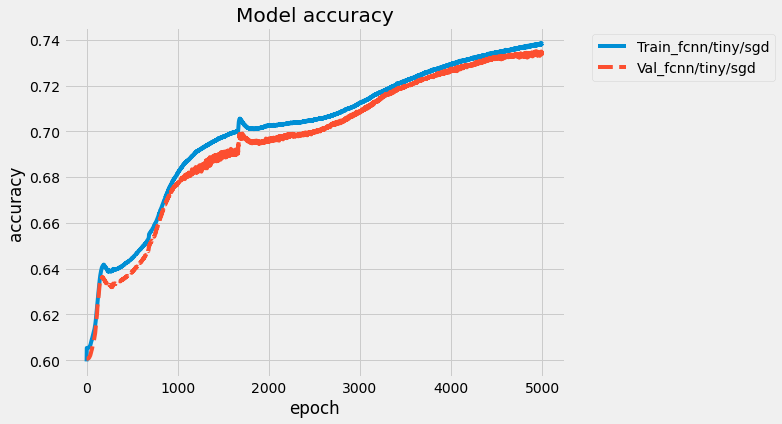

In [17]:
plot_report(size_histories, metric='accuracy')

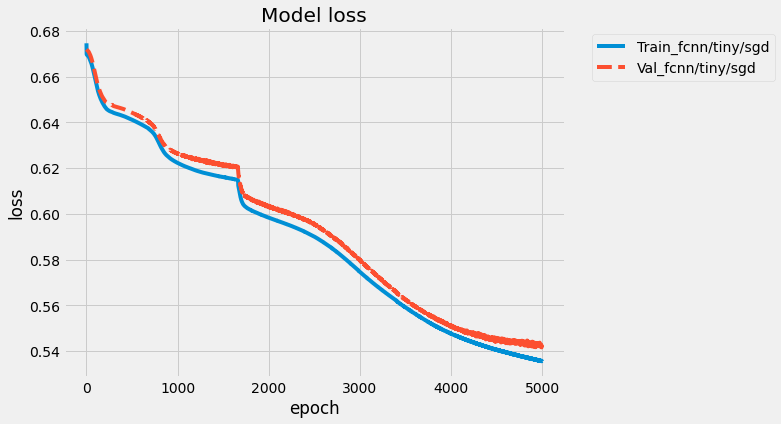

In [18]:
plot_report(size_histories, 'loss')

In [19]:
dense_1 = tf.keras.layers.Dense(main_units, activation=tf.nn.relu)(inputs)
dense_2 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu)(dense_1)
outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dense_2)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

size_histories['fcnn/small/sgd'] = compile_and_fit(model, train_dataset, 
                                              test_dataset,loss='binary_crossentropy',
                                              optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense (Dense)               (None, 64)                3264      
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,321
Trainable params: 4,321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6732 - accuracy: 0.6053 - val_loss: 0.6722 - val_accuracy: 0.6006
Epoch 2/5000
1123/1123 [=====================

1123/1123 [==============================] - 2s 2ms/step - loss: 0.6526 - accuracy: 0.6209 - val_loss: 0.6555 - val_accuracy: 0.6205
Epoch 51/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6520 - accuracy: 0.6220 - val_loss: 0.6549 - val_accuracy: 0.6221
Epoch 52/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6514 - accuracy: 0.6231 - val_loss: 0.6543 - val_accuracy: 0.6236
Epoch 53/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6508 - accuracy: 0.6242 - val_loss: 0.6537 - val_accuracy: 0.6247
Epoch 54/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6501 - accuracy: 0.6254 - val_loss: 0.6531 - val_accuracy: 0.6260
Epoch 55/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6495 - accuracy: 0.6265 - val_loss: 0.6524 - val_accuracy: 0.6274
Epoch 56/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6489 - accuracy: 0.6276 - val_loss: 0.6518 - val_ac

Epoch 106/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6199 - accuracy: 0.6583 - val_loss: 0.6237 - val_accuracy: 0.6510
Epoch 107/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6195 - accuracy: 0.6586 - val_loss: 0.6235 - val_accuracy: 0.6514
Epoch 108/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6192 - accuracy: 0.6585 - val_loss: 0.6232 - val_accuracy: 0.6516
Epoch 109/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6189 - accuracy: 0.6588 - val_loss: 0.6230 - val_accuracy: 0.6518
Epoch 110/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6186 - accuracy: 0.6591 - val_loss: 0.6228 - val_accuracy: 0.6518
Epoch 111/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6183 - accuracy: 0.6591 - val_loss: 0.6225 - val_accuracy: 0.6520
Epoch 112/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6180 - accuracy: 0.6591 - val_

1123/1123 [==============================] - 2s 2ms/step - loss: 0.6105 - accuracy: 0.6652 - val_loss: 0.6133 - val_accuracy: 0.6575
Epoch 162/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6103 - accuracy: 0.6653 - val_loss: 0.6132 - val_accuracy: 0.6585
Epoch 163/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6102 - accuracy: 0.6653 - val_loss: 0.6131 - val_accuracy: 0.6590
Epoch 164/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6101 - accuracy: 0.6651 - val_loss: 0.6131 - val_accuracy: 0.6585
Epoch 165/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6100 - accuracy: 0.6654 - val_loss: 0.6128 - val_accuracy: 0.6591
Epoch 166/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6099 - accuracy: 0.6657 - val_loss: 0.6126 - val_accuracy: 0.6594
Epoch 167/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6098 - accuracy: 0.6658 - val_loss: 0.6125 - 

1123/1123 [==============================] - 2s 2ms/step - loss: 0.6041 - accuracy: 0.6717 - val_loss: 0.6076 - val_accuracy: 0.6700
Epoch 217/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6039 - accuracy: 0.6720 - val_loss: 0.6083 - val_accuracy: 0.6688
Epoch 218/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6038 - accuracy: 0.6722 - val_loss: 0.6083 - val_accuracy: 0.6698
Epoch 219/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6038 - accuracy: 0.6720 - val_loss: 0.6083 - val_accuracy: 0.6705
Epoch 220/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6035 - accuracy: 0.6725 - val_loss: 0.6076 - val_accuracy: 0.6692
Epoch 221/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6034 - accuracy: 0.6724 - val_loss: 0.6076 - val_accuracy: 0.6695
Epoch 222/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.6033 - accuracy: 0.6726 - val_loss: 0.6082 - 

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5974 - accuracy: 0.6809 - val_loss: 0.6012 - val_accuracy: 0.6790
Epoch 272/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5971 - accuracy: 0.6810 - val_loss: 0.6038 - val_accuracy: 0.6775
Epoch 273/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5970 - accuracy: 0.6809 - val_loss: 0.6013 - val_accuracy: 0.6788
Epoch 274/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5969 - accuracy: 0.6816 - val_loss: 0.5994 - val_accuracy: 0.6803
Epoch 275/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5969 - accuracy: 0.6816 - val_loss: 0.6008 - val_accuracy: 0.6789
Epoch 276/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5967 - accuracy: 0.6816 - val_loss: 0.6011 - val_accuracy: 0.6786
Epoch 277/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5964 - accuracy: 0.6820 - val_loss: 0.6031 - 

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5892 - accuracy: 0.6915 - val_loss: 0.5934 - val_accuracy: 0.6922
Epoch 327/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5889 - accuracy: 0.6916 - val_loss: 0.5921 - val_accuracy: 0.6934
Epoch 328/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5890 - accuracy: 0.6918 - val_loss: 0.5944 - val_accuracy: 0.6905
Epoch 329/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5883 - accuracy: 0.6925 - val_loss: 0.5994 - val_accuracy: 0.6854
Epoch 330/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5883 - accuracy: 0.6928 - val_loss: 0.5922 - val_accuracy: 0.6941
Epoch 331/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5879 - accuracy: 0.6928 - val_loss: 0.5917 - val_accuracy: 0.6939
Epoch 332/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5880 - accuracy: 0.6928 - val_loss: 0.5903 - 

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5745 - accuracy: 0.7066 - val_loss: 0.5752 - val_accuracy: 0.7085
Epoch 382/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5746 - accuracy: 0.7068 - val_loss: 0.5772 - val_accuracy: 0.7067
Epoch 383/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5742 - accuracy: 0.7070 - val_loss: 0.5777 - val_accuracy: 0.7067
Epoch 384/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5732 - accuracy: 0.7078 - val_loss: 0.5815 - val_accuracy: 0.7023
Epoch 385/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5730 - accuracy: 0.7084 - val_loss: 0.5790 - val_accuracy: 0.7053
Epoch 386/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5732 - accuracy: 0.7084 - val_loss: 0.5708 - val_accuracy: 0.7088
Epoch 387/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5720 - accuracy: 0.7088 - val_loss: 0.5771 - 

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5594 - accuracy: 0.7180 - val_loss: 0.5574 - val_accuracy: 0.7195
Epoch 437/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5601 - accuracy: 0.7177 - val_loss: 0.5588 - val_accuracy: 0.7181
Epoch 438/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5588 - accuracy: 0.7186 - val_loss: 0.5659 - val_accuracy: 0.7115
Epoch 439/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5593 - accuracy: 0.7186 - val_loss: 0.5630 - val_accuracy: 0.7146
Epoch 440/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5595 - accuracy: 0.7184 - val_loss: 0.5598 - val_accuracy: 0.7199
Epoch 441/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5595 - accuracy: 0.7180 - val_loss: 0.5564 - val_accuracy: 0.7194
Epoch 442/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5592 - accuracy: 0.7182 - val_loss: 0.5595 - 

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5549 - accuracy: 0.7213 - val_loss: 0.5590 - val_accuracy: 0.7187
Epoch 492/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5538 - accuracy: 0.7223 - val_loss: 0.5500 - val_accuracy: 0.7229
Epoch 493/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5531 - accuracy: 0.7227 - val_loss: 0.5584 - val_accuracy: 0.7169
Epoch 494/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5527 - accuracy: 0.7221 - val_loss: 0.5525 - val_accuracy: 0.7205
Epoch 495/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5528 - accuracy: 0.7227 - val_loss: 0.5514 - val_accuracy: 0.7222
Epoch 496/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5525 - accuracy: 0.7235 - val_loss: 0.5489 - val_accuracy: 0.7254
Epoch 497/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5540 - accuracy: 0.7218 - val_loss: 0.5593 - 

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5494 - accuracy: 0.7250 - val_loss: 0.5564 - val_accuracy: 0.7170
Epoch 547/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5507 - accuracy: 0.7249 - val_loss: 0.5562 - val_accuracy: 0.7199
Epoch 548/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5507 - accuracy: 0.7242 - val_loss: 0.5521 - val_accuracy: 0.7206
Epoch 549/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5510 - accuracy: 0.7240 - val_loss: 0.5517 - val_accuracy: 0.7220
Epoch 550/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5499 - accuracy: 0.7246 - val_loss: 0.5546 - val_accuracy: 0.7200
Epoch 551/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5497 - accuracy: 0.7247 - val_loss: 0.5473 - val_accuracy: 0.7279
Epoch 552/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5493 - accuracy: 0.7256 - val_loss: 0.5595 - 

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5471 - accuracy: 0.7266 - val_loss: 0.5475 - val_accuracy: 0.7244
Epoch 602/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5458 - accuracy: 0.7268 - val_loss: 0.5454 - val_accuracy: 0.7266
Epoch 603/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5466 - accuracy: 0.7269 - val_loss: 0.5403 - val_accuracy: 0.7302
Epoch 604/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5462 - accuracy: 0.7268 - val_loss: 0.5440 - val_accuracy: 0.7273
Epoch 605/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5459 - accuracy: 0.7271 - val_loss: 0.5520 - val_accuracy: 0.7222
Epoch 606/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5471 - accuracy: 0.7266 - val_loss: 0.5433 - val_accuracy: 0.7271
Epoch 607/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5476 - accuracy: 0.7254 - val_loss: 0.5467 - 

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5441 - accuracy: 0.7281 - val_loss: 0.5418 - val_accuracy: 0.7302
Epoch 657/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5434 - accuracy: 0.7290 - val_loss: 0.5447 - val_accuracy: 0.7270
Epoch 658/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5430 - accuracy: 0.7289 - val_loss: 0.5405 - val_accuracy: 0.7293
Epoch 659/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5428 - accuracy: 0.7283 - val_loss: 0.5405 - val_accuracy: 0.7303
Epoch 660/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5426 - accuracy: 0.7287 - val_loss: 0.5517 - val_accuracy: 0.7236
Epoch 661/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5443 - accuracy: 0.7266 - val_loss: 0.5382 - val_accuracy: 0.7315
Epoch 662/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5434 - accuracy: 0.7284 - val_loss: 0.5419 - 

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5412 - accuracy: 0.7295 - val_loss: 0.5450 - val_accuracy: 0.7257
Epoch 712/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5408 - accuracy: 0.7295 - val_loss: 0.5468 - val_accuracy: 0.7233
Epoch 713/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5415 - accuracy: 0.7294 - val_loss: 0.5384 - val_accuracy: 0.7315
Epoch 714/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5415 - accuracy: 0.7293 - val_loss: 0.5403 - val_accuracy: 0.7285
Epoch 715/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5410 - accuracy: 0.7293 - val_loss: 0.5444 - val_accuracy: 0.7265
Epoch 716/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5405 - accuracy: 0.7303 - val_loss: 0.5422 - val_accuracy: 0.7292
Epoch 717/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5407 - accuracy: 0.7298 - val_loss: 0.5444 - 

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5394 - accuracy: 0.7304 - val_loss: 0.5428 - val_accuracy: 0.7252
Epoch 767/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5389 - accuracy: 0.7314 - val_loss: 0.5349 - val_accuracy: 0.7337
Epoch 768/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5393 - accuracy: 0.7305 - val_loss: 0.5427 - val_accuracy: 0.7280
Epoch 769/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5394 - accuracy: 0.7307 - val_loss: 0.5344 - val_accuracy: 0.7337
Epoch 770/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5389 - accuracy: 0.7305 - val_loss: 0.5431 - val_accuracy: 0.7283
Epoch 771/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5384 - accuracy: 0.7310 - val_loss: 0.5411 - val_accuracy: 0.7282
Epoch 772/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5389 - accuracy: 0.7311 - val_loss: 0.5405 - 

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5365 - accuracy: 0.7327 - val_loss: 0.5402 - val_accuracy: 0.7308
Epoch 822/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5361 - accuracy: 0.7329 - val_loss: 0.5436 - val_accuracy: 0.7296
Epoch 823/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5367 - accuracy: 0.7330 - val_loss: 0.5361 - val_accuracy: 0.7324
Epoch 824/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5364 - accuracy: 0.7322 - val_loss: 0.5366 - val_accuracy: 0.7330
Epoch 825/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5365 - accuracy: 0.7325 - val_loss: 0.5422 - val_accuracy: 0.7291
Epoch 826/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5370 - accuracy: 0.7321 - val_loss: 0.5401 - val_accuracy: 0.7310
Epoch 827/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5366 - accuracy: 0.7325 - val_loss: 0.5349 - 

1123/1123 [==============================] - 2s 2ms/step - loss: 0.5350 - accuracy: 0.7335 - val_loss: 0.5374 - val_accuracy: 0.7335
Epoch 877/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5355 - accuracy: 0.7326 - val_loss: 0.5369 - val_accuracy: 0.7323
Epoch 878/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5348 - accuracy: 0.7335 - val_loss: 0.5387 - val_accuracy: 0.7317
Epoch 879/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5351 - accuracy: 0.7331 - val_loss: 0.5409 - val_accuracy: 0.7298
Epoch 880/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5348 - accuracy: 0.7334 - val_loss: 0.5363 - val_accuracy: 0.7328
Epoch 881/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5348 - accuracy: 0.7334 - val_loss: 0.5433 - val_accuracy: 0.7298
Epoch 882/5000
1123/1123 [==============================] - 2s 2ms/step - loss: 0.5355 - accuracy: 0.7332 - val_loss: 0.5335 - 

KeyboardInterrupt: 

In [ ]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

In [ ]:
plot_report(size_histories)

In [ ]:
plot_report(size_histories, 'loss')

In [ ]:
dense_1 = tf.keras.layers.Dense(main_units, activation=tf.nn.relu)(inputs)
dense_2 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu)(dense_1)
dense_3 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.sigmoid)(dense_2)
dense_4 = tf.keras.layers.Dense(last_unit, activation=tf.nn.sigmoid)(dense_3)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dense_4)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

size_histories['fcnn/large/sgd'] = compile_and_fit(model, train_dataset, 
                                              test_dataset,
                                              loss='binary_crossentropy',
                                              optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

In [ ]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

In [ ]:
plot_report(size_histories)

In [ ]:
plot_report(size_histories, 'loss')

### Dropout

Although we got an accuracy of 0.75 looking at loss function chart is pretty obvious: There is overfiting. Now we have an overfitted NN let's make some adjustments to improve generalization capacity startin from dropout techniques.  

In [ ]:
dense_1 = tf.keras.layers.Dense(main_units, activation=tf.nn.relu)(inputs)
dropout_1 = tf.keras.layers.Dropout(dr)(dense_1)
dense_2 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu)(dropout_1)
dropout_2 = tf.keras.layers.Dropout(dr)(dense_2)
dense_3 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.sigmoid)(dropout_2)
dropout_3 = tf.keras.layers.Dropout(dr)(dense_3)
dense_4 = tf.keras.layers.Dense(last_unit, activation=tf.nn.sigmoid)(dropout_3)
dropout_4 = tf.keras.layers.Dropout(dr)(dense_4)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dropout_4)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

size_histories['fcnn/large/dropout/sgd'] = compile_and_fit(model, 
                                                      train_dataset,
                                                      test_dataset,
                                                      optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                                      max_epochs=num_epochs,
                                                      loss='binary_crossentropy')

In [ ]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

In [ ]:
plot_report(size_histories)

Validation accuracy keeps improving more epoch with a total improvement from 0.75 to 0.81. Furthemore, the gap between training loss function and test loss function has been reduced.

In [ ]:
plot_report(size_histories, metric='loss')

### Kernel regularizer

In [ ]:
# shutil.rmtree(logdir/'regularizers/tiny', ignore_errors=True)
# shutil.copytree(logdir/'fcnn/tiny', logdir/'regularizers/tiny')
regularizer_histories = {}
regularizer_histories['large'] = size_histories['fcnn/large/sgd']
regularizer_histories['dropout'] = size_histories['fcnn/large/dropout/sgd']

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights. one reason why L2 is more common.

In tf.keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [ ]:
dense_1 = tf.keras.layers.Dense(main_units, activation=tf.nn.relu,kernel_regularizer=regularizers.l1(lr1))(inputs)
dense_2 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu,kernel_regularizer=regularizers.l1(lr1))(dense_1)
dense_3 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu,kernel_regularizer=regularizers.l1(lr1))(dense_2)
dense_4 = tf.keras.layers.Dense(last_unit, activation=tf.nn.relu,kernel_regularizer=regularizers.l1(lr1))(dense_3)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dense_4)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

regularizer_histories['fcnn/large/l2/sgd'] = compile_and_fit(model, train_dataset, 
                                              test_dataset, 
                                              optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              loss="binary_crossentropy",
                                            max_epochs=num_epochs)

In [ ]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

In [ ]:
plot_report(regularizer_histories, 'accuracy')

In [ ]:
plot_report(regularizer_histories, 'loss')

Now let's see what happens combining both techniques

In [ ]:
dense_1 = tf.keras.layers.Dense(main_units, activation=tf.nn.relu, kernel_regularizer=regularizers.l1(lr1))(inputs)
dropout_1 = tf.keras.layers.Dropout(dr)(inputs)
dense_2 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu, kernel_regularizer=regularizers.l1(lr1))(dropout_1)
dropout_2 = tf.keras.layers.Dropout(dr)(dense_2)
dense_3 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l1(lr1))(dropout_2)
dropout_3 = tf.keras.layers.Dropout(dr)(dense_3)
dense_4 = tf.keras.layers.Dense(last_unit, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l1(lr1))(dropout_3)
dropout_4 = tf.keras.layers.Dropout(dr)(dense_4)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dense_4)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

regularizer_histories['fcnn/large/combined/sgd'] = compile_and_fit(model, train_dataset, test_dataset, 
                                                    loss="binary_crossentropy",
                                                    optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                                    max_epochs=num_epochs)

In [ ]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

In [ ]:
plot_report(regularizer_histories, 'accuracy')

In [ ]:
plot_report(regularizer_histories, 'loss')

## Batch Normalization

Batch normalization (also known as batch norm) is a method used to make artificial neural networks faster and more stable through normalization of the input layer by re-centering and re-scaling. It was proposed by Sergey Ioffe and Christian Szegedy in 2015.

[Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

[Tensorflow implementation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)


In [ ]:
batch_histories = {}
batch_histories['large'] = size_histories['fcnn/large/sgd']
batch_histories['dropout'] = size_histories['fcnn/large/dropout/sgd']

In [ ]:
dense_1 = tf.keras.layers.Dense(main_units, activation=tf.nn.relu, kernel_regularizer=regularizers.l1(lr1))(inputs)
norm_1 = tf.keras.layers.BatchNormalization()(inputs)
dense_2 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu, kernel_regularizer=regularizers.l1(lr1))(norm_1)
norm_2 = tf.keras.layers.BatchNormalization()(dense_2)
dense_3 = tf.keras.layers.Dense(secondary_units, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l1(lr1))(norm_2)
norm_3 = tf.keras.layers.BatchNormalization()(dense_3)
dense_4 = tf.keras.layers.Dense(last_unit, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l1(lr1))(norm_3)
norm_4 = tf.keras.layers.BatchNormalization()(dense_4)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(norm_4)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

batch_histories['fcnn/small/batch/sgd'] = compile_and_fit(model, train_dataset, test_dataset, 
                                                    loss="binary_crossentropy",
                                                    optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                                    max_epochs=num_epochs)

In [ ]:
batch_histories['fcnn/small/batch/sgd'].history['accuracy'][-1], batch_histories['fcnn/small/batch/sgd'].history['val_accuracy'][-1]

In [ ]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

In [ ]:
plot_report(batch_histories, 'accuracy')

In [ ]:
plot_report(batch_histories, 'loss')

## LSTM-FCNN

Univariate time series classification model, the Long Short Term Memory Fully Convolutional Network (LSTM-FCN) to capture time related information

In [ ]:
lstm_histories = {}
lstm_histories['large'] = size_histories['fcnn/large/sgd']
lstm_histories['dropout'] = size_histories['fcnn/large/dropout/sgd']

In [ ]:
lambda_1 = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(inputs)# expand the dimension form (50, 4096) to (50, 4096, 1)
lstm_1 = tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False)(lambda_1)
dense_1 = tf.keras.layers.Dense(last_unit, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l1(lr1))(lstm_1)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dense_1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

lstm_histories['lstm/tiny'] = compile_and_fit(model, train_dataset, test_dataset, 
                                                    loss="binary_crossentropy",
                                                    optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                                    max_epochs=num_epochs)

In [ ]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

In [ ]:
plot_report(lstm_histories, 'accuracy')

In [ ]:
plot_report(lstm_histories, 'loss')

In [ ]:
lstm_1 = tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True)(lambda_1)
lstm_2 = tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False)(lstm_1)

dense_1 = tf.keras.layers.Dense(last_unit, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l1(lr1))(lstm_2)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dense_1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

lstm_histories['lstm/small'] = compile_and_fit(model, train_dataset, test_dataset, 
                                                    loss="binary_crossentropy",
                                                    optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                                    max_epochs=num_epochs)


In [ ]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

In [ ]:
plot_report(lstm_histories, 'accuracy')

In [ ]:
plot_report(lstm_histories, 'loss')

In [ ]:
lstm_1 = tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True)(lambda_1)
lstm_2 = tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True)(lstm_1)
lstm_3 = tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False)(lstm_2)

dense_1 = tf.keras.layers.Dense(last_unit, activation=tf.nn.sigmoid, kernel_regularizer=regularizers.l1(lr1))(lstm_3)

outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)(dense_1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

lstm_histories['lstm/large'] = compile_and_fit(model, train_dataset, test_dataset, 
                                                    loss="binary_crossentropy",
                                                    optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                                    max_epochs=num_epochs)

In [ ]:
for value, name in zip(model.evaluate(train_dataset), model.metrics_names):
    print('training', name, ':', value)
for value, name in zip(model.evaluate(test_dataset), model.metrics_names):
    print('test', name, ':', value)

In [ ]:
plot_report(lstm_histories, 'accuracy')

In [ ]:
plot_report(lstm_histories, 'loss')